In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [5]:
good_data_file = 'normedRateAvg_TenInputs_data.pickle'
bad_data_file = 'normedRateAvg_TenInputs_bad.pickle'

subplot_size = [4,3]
fig_size = [20,20]

runs = [304125,304508,302263]

with open(good_data_file, 'rb') as handle:
    data = pickle.load(handle)
with open(bad_data_file, 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])

num_rates = len(x_train[0])

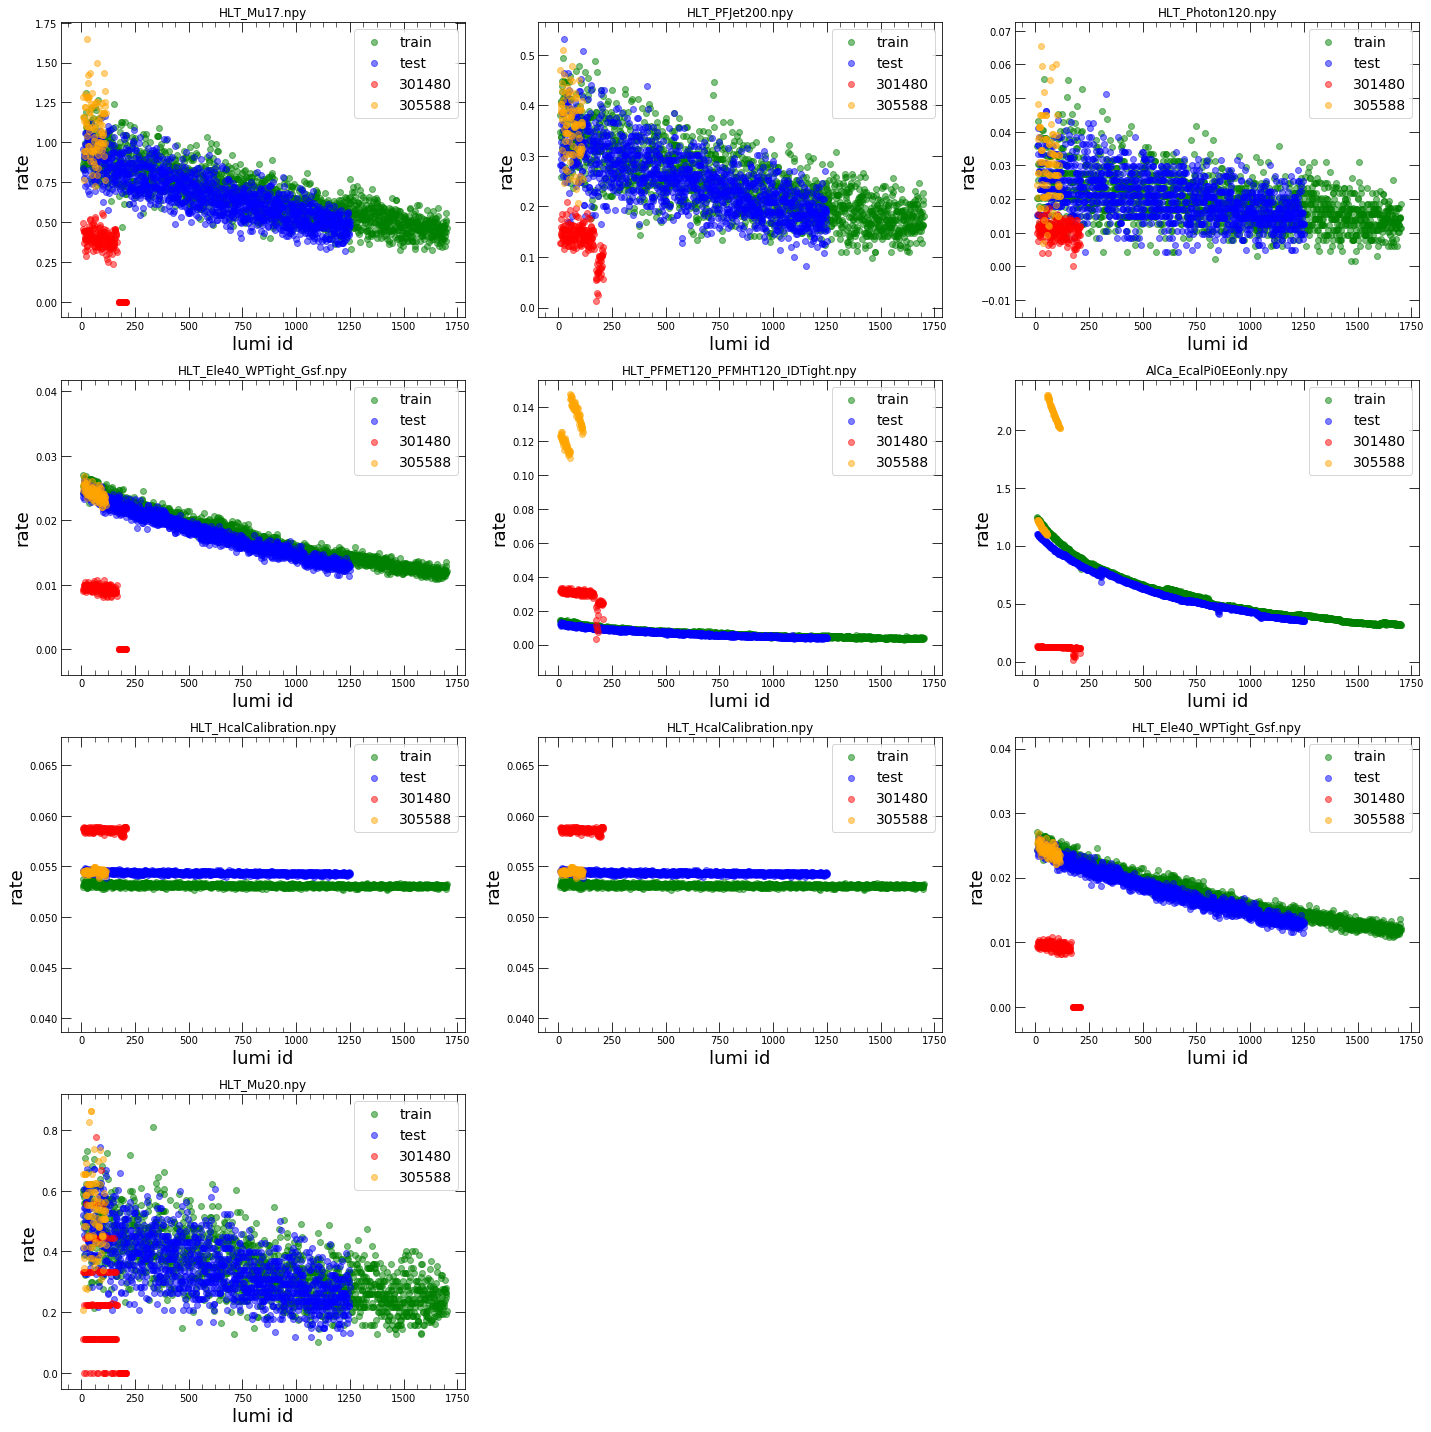

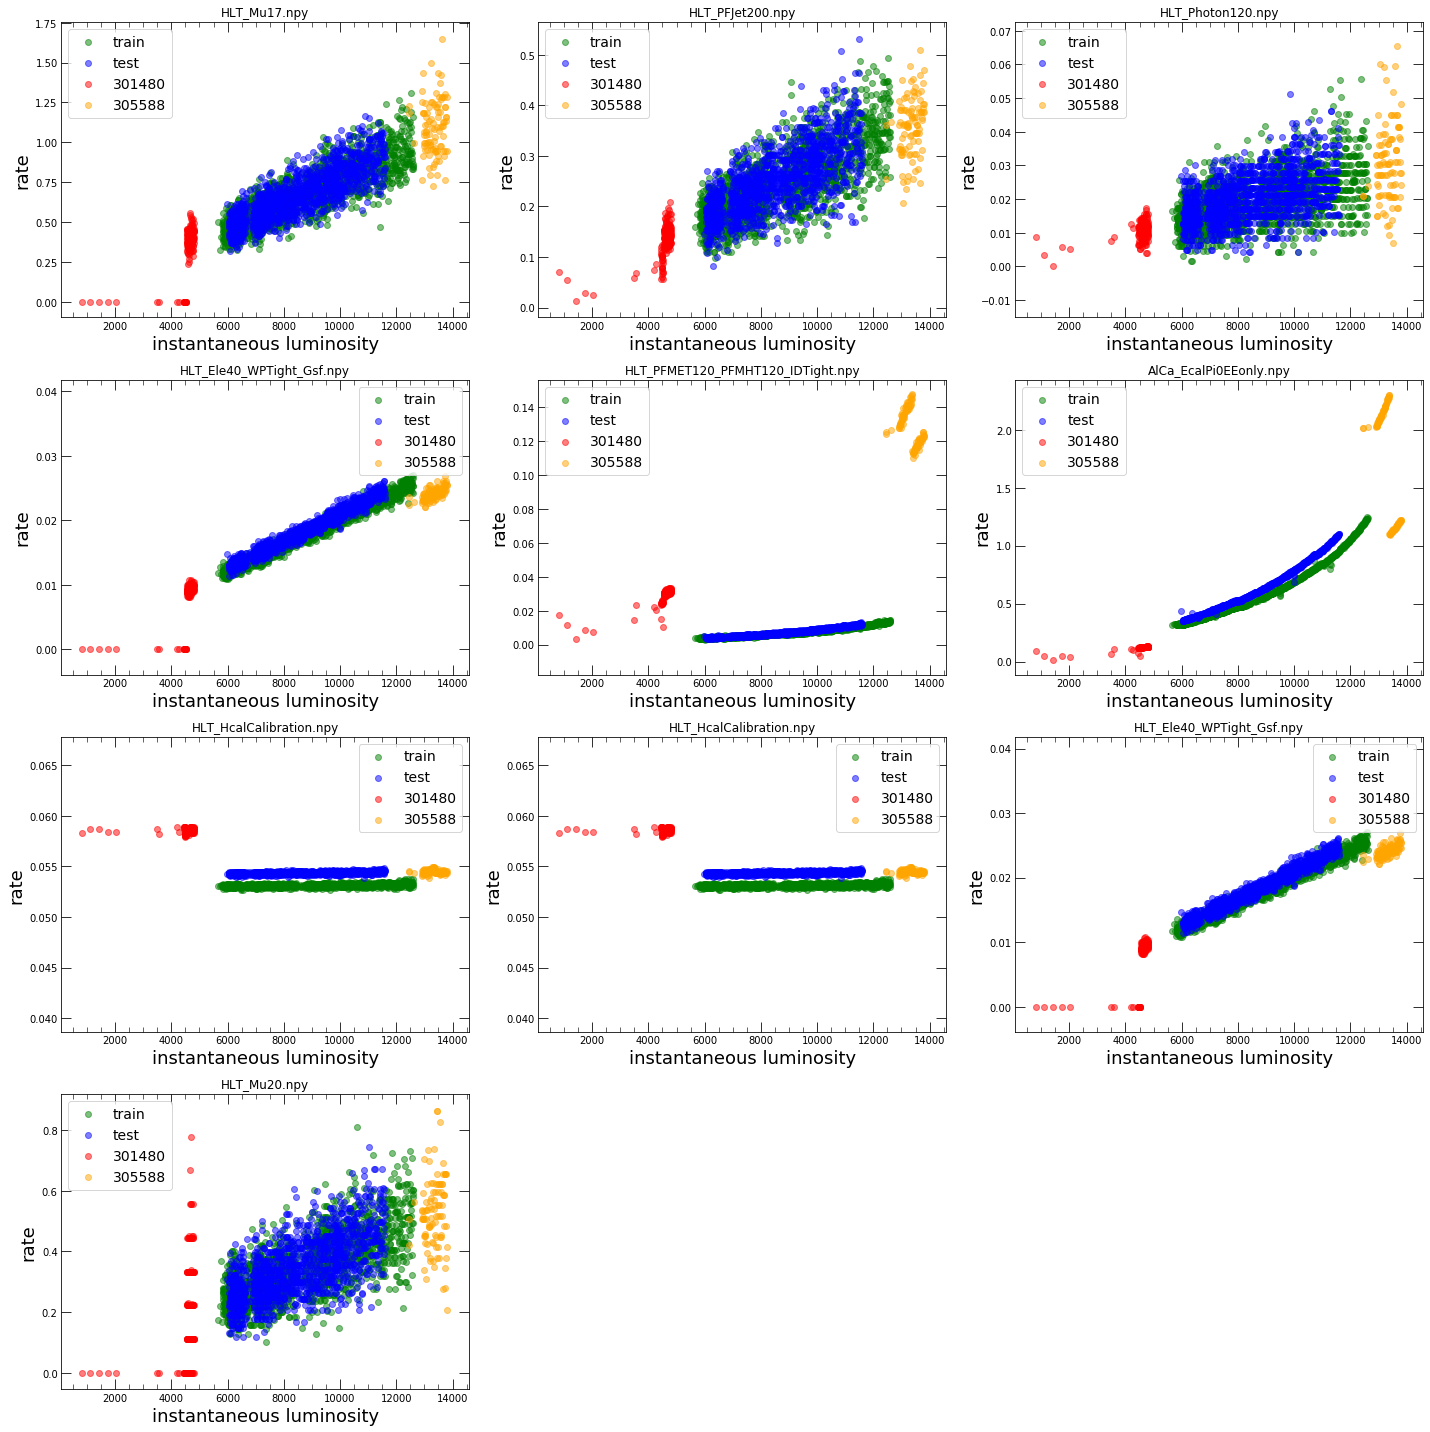

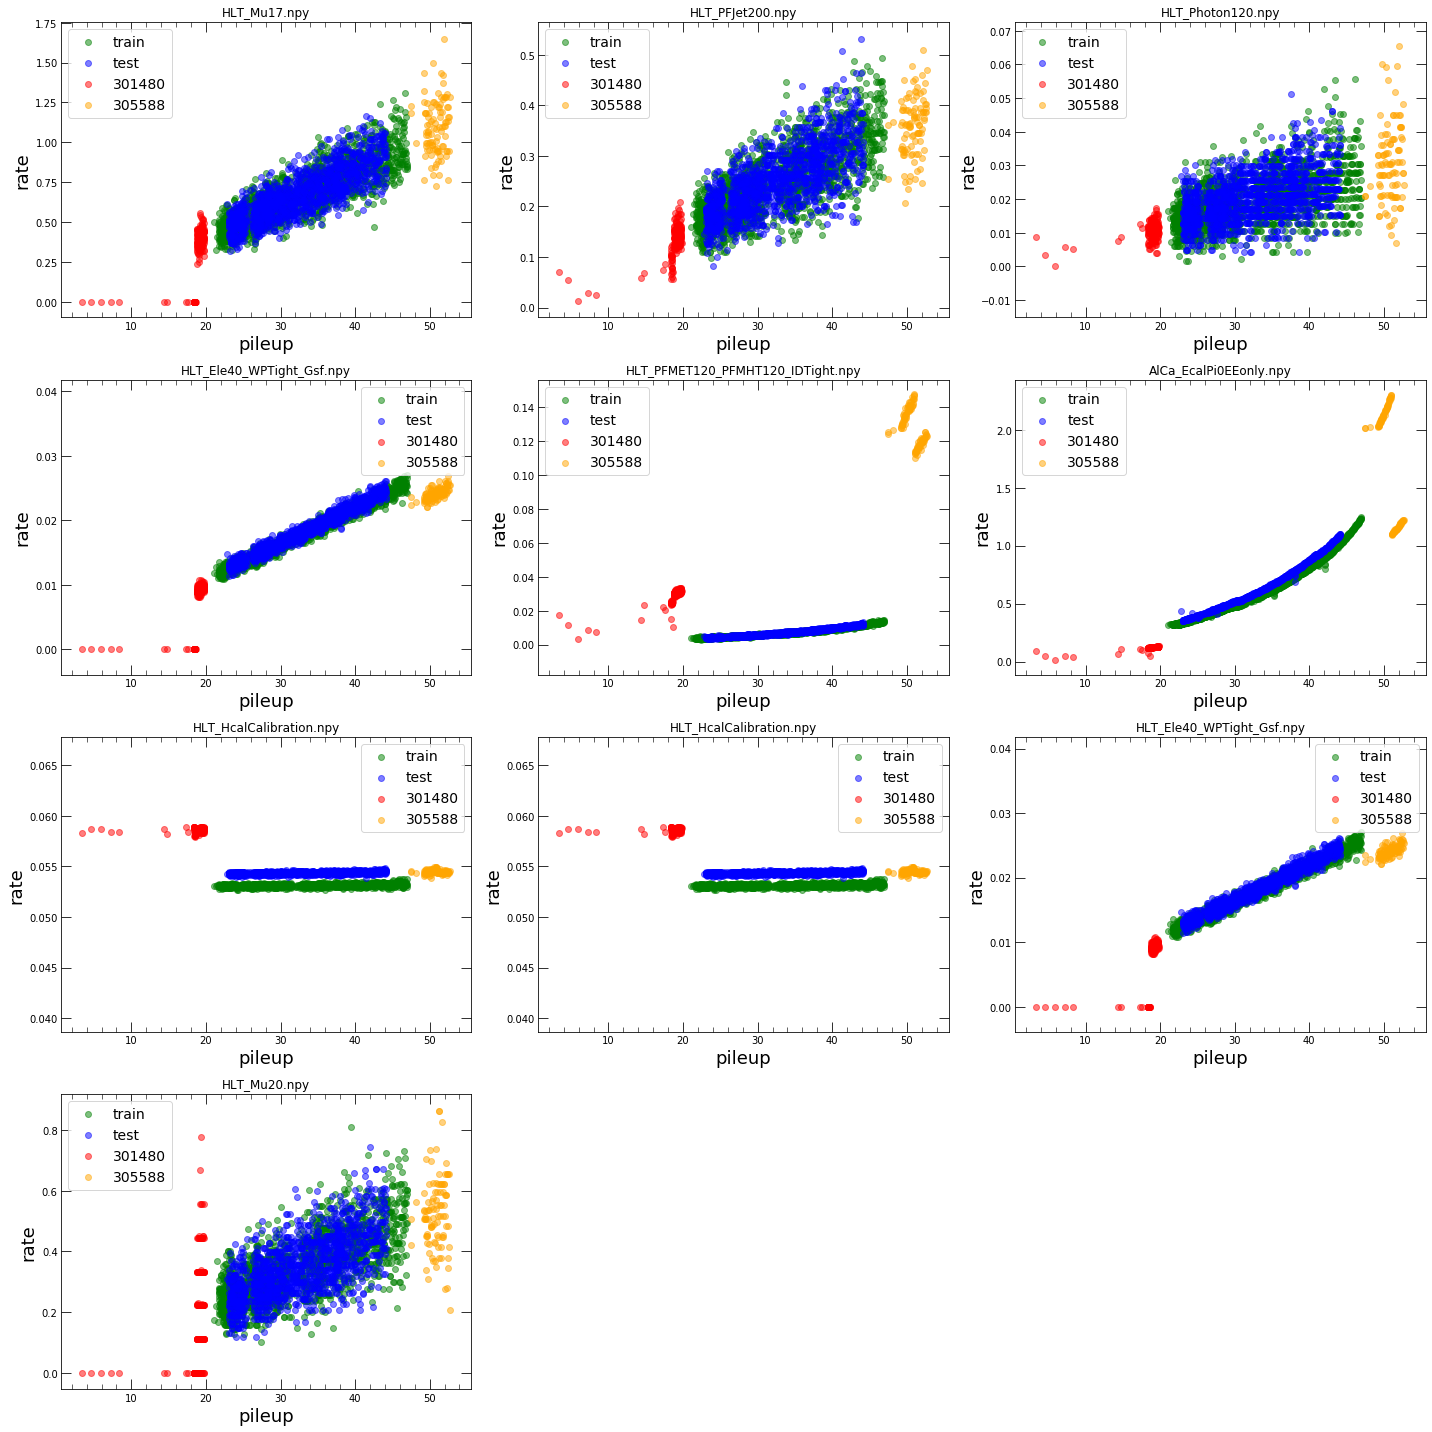

In [6]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(len(plots)):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    for k in range(len(plots)):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=fig_size)
              
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    for k in range(len(plots)):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=fig_size)
              
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    for k in range(len(plots)):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [7]:
model_name = "normedRateAvgTenInputsSimple"

In [8]:
# Define the architecture

_input = Input(shape=(10,), name="input")

middlein = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="middlein")(_input)

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="encoded")(middlein)

middleout = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="middleout")(hidden)

output = Dense(10,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(middleout)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10)                0         
_________________________________________________________________
middlein (Dense)             (None, 6)                 66        
_________________________________________________________________
encoded (Dense)              (None, 3)                 21        
_________________________________________________________________
middleout (Dense)            (None, 6)                 24        
_________________________________________________________________
reconstructed (Dense)        (None, 10)                70        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 6s - loss: 157182.0982 - val_loss: 158468.6867
Epoch 2/1000
 - 0s - loss: 150379.6611 - val_loss: 151214.3663
Epoch 3/1000
 - 0s - loss: 143461.9634 - val_loss: 144168.7618
Epoch 4/1000
 - 0s - loss: 136790.9335 - val_loss: 137342.4999
Epoch 5/1000
 - 0s - loss: 130333.5166 - val_loss: 130843.6989
Epoch 6/1000
 - 0s - loss: 124164.5924 - val_loss: 124669.0752
Epoch 7/1000
 - 0s - loss: 118272.6328 - val_loss: 118798.5376
Epoch 8/1000
 - 0s - loss: 112721.6772 - val_loss: 113217.0427
Epoch 9/1000
 - 0s - loss: 107429.4264 - val_loss: 107927.5770
Epoch 10/1000
 - 0s - loss: 102421.1085 - val_loss: 102919.8802
Epoch 11/1000
 - 0s - loss: 97682.9828 - val_loss: 98210.0467
Epoch 12/1000
 - 0s - loss: 93228.5813 - val_loss: 93759.6958
Epoch 13/1000
 - 0s - loss: 88998.6353 - val_loss: 89558.4180
Epoch 14/1000
 - 0s - loss: 85024.1457 - val_loss: 85567.8775
Epoch 15/1000
 - 0s - loss: 81240.3926 - val_loss: 81802.0345
Epoch 16/10

Epoch 133/1000
 - 0s - loss: 5293.7996 - val_loss: 5469.5601
Epoch 134/1000
 - 0s - loss: 5225.0542 - val_loss: 5398.8046
Epoch 135/1000
 - 0s - loss: 5157.6224 - val_loss: 5329.2866
Epoch 136/1000
 - 0s - loss: 5091.0052 - val_loss: 5261.1795
Epoch 137/1000
 - 0s - loss: 5026.2029 - val_loss: 5194.3561
Epoch 138/1000
 - 0s - loss: 4962.3136 - val_loss: 5128.7318
Epoch 139/1000
 - 0s - loss: 4899.6612 - val_loss: 5064.3566
Epoch 140/1000
 - 0s - loss: 4838.2279 - val_loss: 5001.1370
Epoch 141/1000
 - 0s - loss: 4778.0229 - val_loss: 4939.0408
Epoch 142/1000
 - 0s - loss: 4718.7483 - val_loss: 4877.9816
Epoch 143/1000
 - 0s - loss: 4660.4402 - val_loss: 4818.0781
Epoch 144/1000
 - 0s - loss: 4603.3687 - val_loss: 4759.2733
Epoch 145/1000
 - 0s - loss: 4547.1791 - val_loss: 4701.4886
Epoch 146/1000
 - 0s - loss: 4491.9259 - val_loss: 4644.7710
Epoch 147/1000
 - 0s - loss: 4437.8182 - val_loss: 4588.9768
Epoch 148/1000
 - 0s - loss: 4384.6344 - val_loss: 4534.1836
Epoch 149/1000
 - 0s - l

Epoch 268/1000
 - 0s - loss: 1438.7565 - val_loss: 1493.4746
Epoch 269/1000
 - 0s - loss: 1428.2561 - val_loss: 1482.5880
Epoch 270/1000
 - 0s - loss: 1417.8295 - val_loss: 1471.8119
Epoch 271/1000
 - 0s - loss: 1407.5660 - val_loss: 1461.1427
Epoch 272/1000
 - 0s - loss: 1397.3925 - val_loss: 1450.5868
Epoch 273/1000
 - 0s - loss: 1387.2844 - val_loss: 1440.1529
Epoch 274/1000
 - 0s - loss: 1377.3070 - val_loss: 1429.8284
Epoch 275/1000
 - 0s - loss: 1367.4227 - val_loss: 1419.6077
Epoch 276/1000
 - 0s - loss: 1357.6522 - val_loss: 1409.4935
Epoch 277/1000
 - 0s - loss: 1348.0091 - val_loss: 1399.4738
Epoch 278/1000
 - 0s - loss: 1338.3935 - val_loss: 1389.5644
Epoch 279/1000
 - 0s - loss: 1328.9273 - val_loss: 1379.7457
Epoch 280/1000
 - 0s - loss: 1319.5387 - val_loss: 1370.0261
Epoch 281/1000
 - 0s - loss: 1310.2514 - val_loss: 1360.4004
Epoch 282/1000
 - 0s - loss: 1301.0438 - val_loss: 1350.8688
Epoch 283/1000
 - 0s - loss: 1291.9321 - val_loss: 1341.4297
Epoch 284/1000
 - 0s - l

Epoch 405/1000
 - 0s - loss: 621.7976 - val_loss: 646.5610
Epoch 406/1000
 - 0s - loss: 618.5819 - val_loss: 643.2303
Epoch 407/1000
 - 0s - loss: 615.3890 - val_loss: 639.9230
Epoch 408/1000
 - 0s - loss: 612.2330 - val_loss: 636.6386
Epoch 409/1000
 - 0s - loss: 609.0926 - val_loss: 633.3767
Epoch 410/1000
 - 0s - loss: 605.9721 - val_loss: 630.1384
Epoch 411/1000
 - 0s - loss: 602.8799 - val_loss: 626.9242
Epoch 412/1000
 - 0s - loss: 599.8008 - val_loss: 623.7336
Epoch 413/1000
 - 0s - loss: 596.7553 - val_loss: 620.5650
Epoch 414/1000
 - 0s - loss: 593.7197 - val_loss: 617.4201
Epoch 415/1000
 - 0s - loss: 590.7154 - val_loss: 614.2970
Epoch 416/1000
 - 0s - loss: 587.7328 - val_loss: 611.1967
Epoch 417/1000
 - 0s - loss: 584.7675 - val_loss: 608.1181
Epoch 418/1000
 - 0s - loss: 581.8252 - val_loss: 605.0626
Epoch 419/1000
 - 0s - loss: 578.8894 - val_loss: 602.0311
Epoch 420/1000
 - 0s - loss: 575.9945 - val_loss: 599.0174
Epoch 421/1000
 - 0s - loss: 573.1104 - val_loss: 596.02

Epoch 544/1000
 - 0s - loss: 329.7349 - val_loss: 343.1827
Epoch 545/1000
 - 0s - loss: 328.4030 - val_loss: 341.7946
Epoch 546/1000
 - 0s - loss: 327.0737 - val_loss: 340.4146
Epoch 547/1000
 - 0s - loss: 325.7543 - val_loss: 339.0426
Epoch 548/1000
 - 0s - loss: 324.4443 - val_loss: 337.6779
Epoch 549/1000
 - 0s - loss: 323.1381 - val_loss: 336.3218
Epoch 550/1000
 - 0s - loss: 321.8390 - val_loss: 334.9733
Epoch 551/1000
 - 0s - loss: 320.5544 - val_loss: 333.6320
Epoch 552/1000
 - 0s - loss: 319.2675 - val_loss: 332.2994
Epoch 553/1000
 - 0s - loss: 317.9889 - val_loss: 330.9740
Epoch 554/1000
 - 0s - loss: 316.7262 - val_loss: 329.6548
Epoch 555/1000
 - 0s - loss: 315.4645 - val_loss: 328.3436
Epoch 556/1000
 - 0s - loss: 314.2098 - val_loss: 327.0401
Epoch 557/1000
 - 0s - loss: 312.9637 - val_loss: 325.7437
Epoch 558/1000
 - 0s - loss: 311.7222 - val_loss: 324.4549
Epoch 559/1000
 - 0s - loss: 310.4895 - val_loss: 323.1733
Epoch 560/1000
 - 0s - loss: 309.2592 - val_loss: 321.89

Epoch 683/1000
 - 0s - loss: 197.4008 - val_loss: 205.5614
Epoch 684/1000
 - 0s - loss: 196.7354 - val_loss: 204.8681
Epoch 685/1000
 - 0s - loss: 196.0706 - val_loss: 204.1782
Epoch 686/1000
 - 0s - loss: 195.4103 - val_loss: 203.4917
Epoch 687/1000
 - 0s - loss: 194.7557 - val_loss: 202.8079
Epoch 688/1000
 - 0s - loss: 194.1007 - val_loss: 202.1278
Epoch 689/1000
 - 0s - loss: 193.4483 - val_loss: 201.4509
Epoch 690/1000
 - 0s - loss: 192.8018 - val_loss: 200.7766
Epoch 691/1000
 - 0s - loss: 192.1561 - val_loss: 200.1057
Epoch 692/1000
 - 0s - loss: 191.5147 - val_loss: 199.4376
Epoch 693/1000
 - 0s - loss: 190.8727 - val_loss: 198.7728
Epoch 694/1000
 - 0s - loss: 190.2402 - val_loss: 198.1102
Epoch 695/1000
 - 0s - loss: 189.6048 - val_loss: 197.4510
Epoch 696/1000
 - 0s - loss: 188.9738 - val_loss: 196.7948
Epoch 697/1000
 - 0s - loss: 188.3465 - val_loss: 196.1414
Epoch 698/1000
 - 0s - loss: 187.7229 - val_loss: 195.4909
Epoch 699/1000
 - 0s - loss: 187.0994 - val_loss: 194.84

Epoch 822/1000
 - 0s - loss: 127.5157 - val_loss: 132.8353
Epoch 823/1000
 - 0s - loss: 127.1426 - val_loss: 132.4469
Epoch 824/1000
 - 0s - loss: 126.7706 - val_loss: 132.0599
Epoch 825/1000
 - 0s - loss: 126.4010 - val_loss: 131.6743
Epoch 826/1000
 - 0s - loss: 126.0300 - val_loss: 131.2904
Epoch 827/1000
 - 0s - loss: 125.6649 - val_loss: 130.9074
Epoch 828/1000
 - 0s - loss: 125.2965 - val_loss: 130.5263
Epoch 829/1000
 - 0s - loss: 124.9329 - val_loss: 130.1462
Epoch 830/1000
 - 0s - loss: 124.5684 - val_loss: 129.7677
Epoch 831/1000
 - 0s - loss: 124.2078 - val_loss: 129.3905
Epoch 832/1000
 - 0s - loss: 123.8447 - val_loss: 129.0151
Epoch 833/1000
 - 0s - loss: 123.4869 - val_loss: 128.6407
Epoch 834/1000
 - 0s - loss: 123.1285 - val_loss: 128.2679
Epoch 835/1000
 - 0s - loss: 122.7719 - val_loss: 127.8965
Epoch 836/1000
 - 0s - loss: 122.4152 - val_loss: 127.5268
Epoch 837/1000
 - 0s - loss: 122.0625 - val_loss: 127.1580
Epoch 838/1000
 - 0s - loss: 121.7094 - val_loss: 126.79

Epoch 963/1000
 - 0s - loss: 86.3252 - val_loss: 89.9498
Epoch 964/1000
 - 0s - loss: 86.1006 - val_loss: 89.7147
Epoch 965/1000
 - 0s - loss: 85.8759 - val_loss: 89.4804
Epoch 966/1000
 - 0s - loss: 85.6504 - val_loss: 89.2472
Epoch 967/1000
 - 0s - loss: 85.4281 - val_loss: 89.0145
Epoch 968/1000
 - 0s - loss: 85.2057 - val_loss: 88.7827
Epoch 969/1000
 - 0s - loss: 84.9828 - val_loss: 88.5519
Epoch 970/1000
 - 0s - loss: 84.7629 - val_loss: 88.3215
Epoch 971/1000
 - 0s - loss: 84.5424 - val_loss: 88.0921
Epoch 972/1000
 - 0s - loss: 84.3232 - val_loss: 87.8635
Epoch 973/1000
 - 0s - loss: 84.1035 - val_loss: 87.6358
Epoch 974/1000
 - 0s - loss: 83.8846 - val_loss: 87.4089
Epoch 975/1000
 - 0s - loss: 83.6681 - val_loss: 87.1823
Epoch 976/1000
 - 0s - loss: 83.4520 - val_loss: 86.9565
Epoch 977/1000
 - 0s - loss: 83.2354 - val_loss: 86.7315
Epoch 978/1000
 - 0s - loss: 83.0200 - val_loss: 86.5072
Epoch 979/1000
 - 0s - loss: 82.8068 - val_loss: 86.2836
Epoch 980/1000
 - 0s - loss: 82

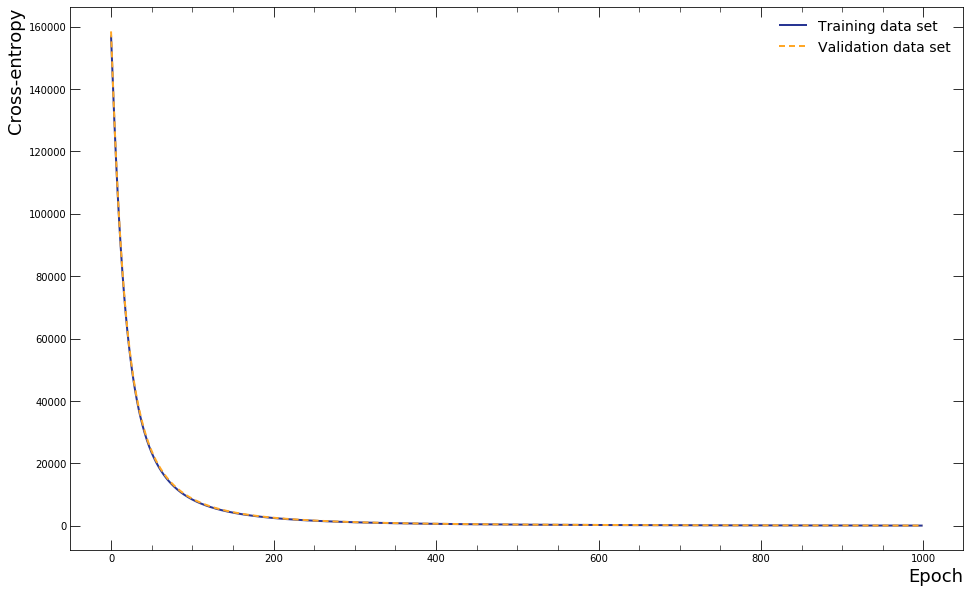

In [9]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

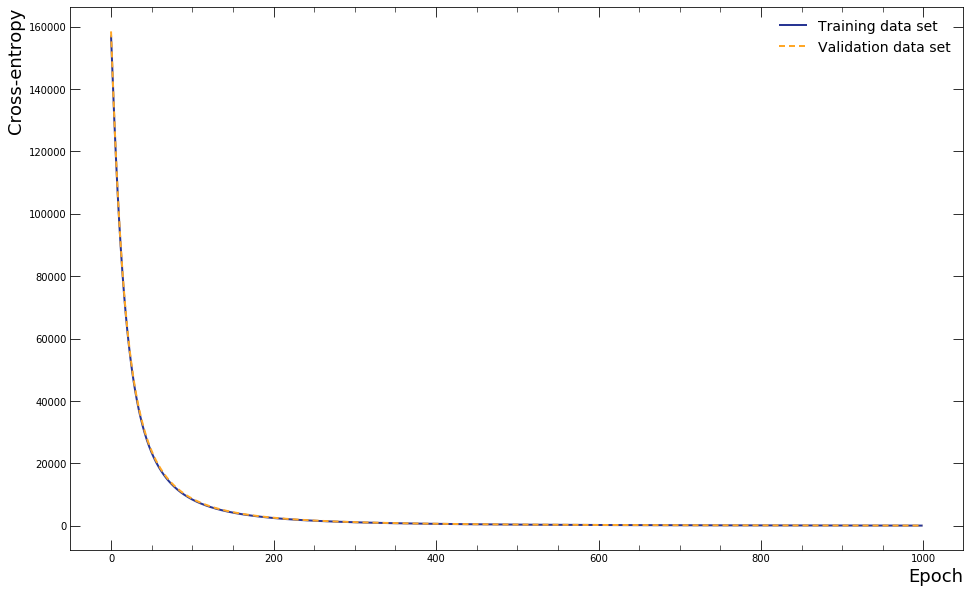

In [10]:
plot_loss(history)

## Training Set

In [11]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

lumi_train = data[str(runs[0])]['lumiid'] 
             
reconstructed_train = model.predict(np.array(x_train))

error = abs(x_train-reconstructed_train)/x_train

In [12]:
error_train_reformat = []
inp = []
outp = []
for i in range(num_rates):
    error_train_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    for j in range(num_rates):
        error_train_reformat[j].append(error[i][j])
        outp[j].append(reconstructed_train[i][j])
        inp[j].append(x_train[i][j])

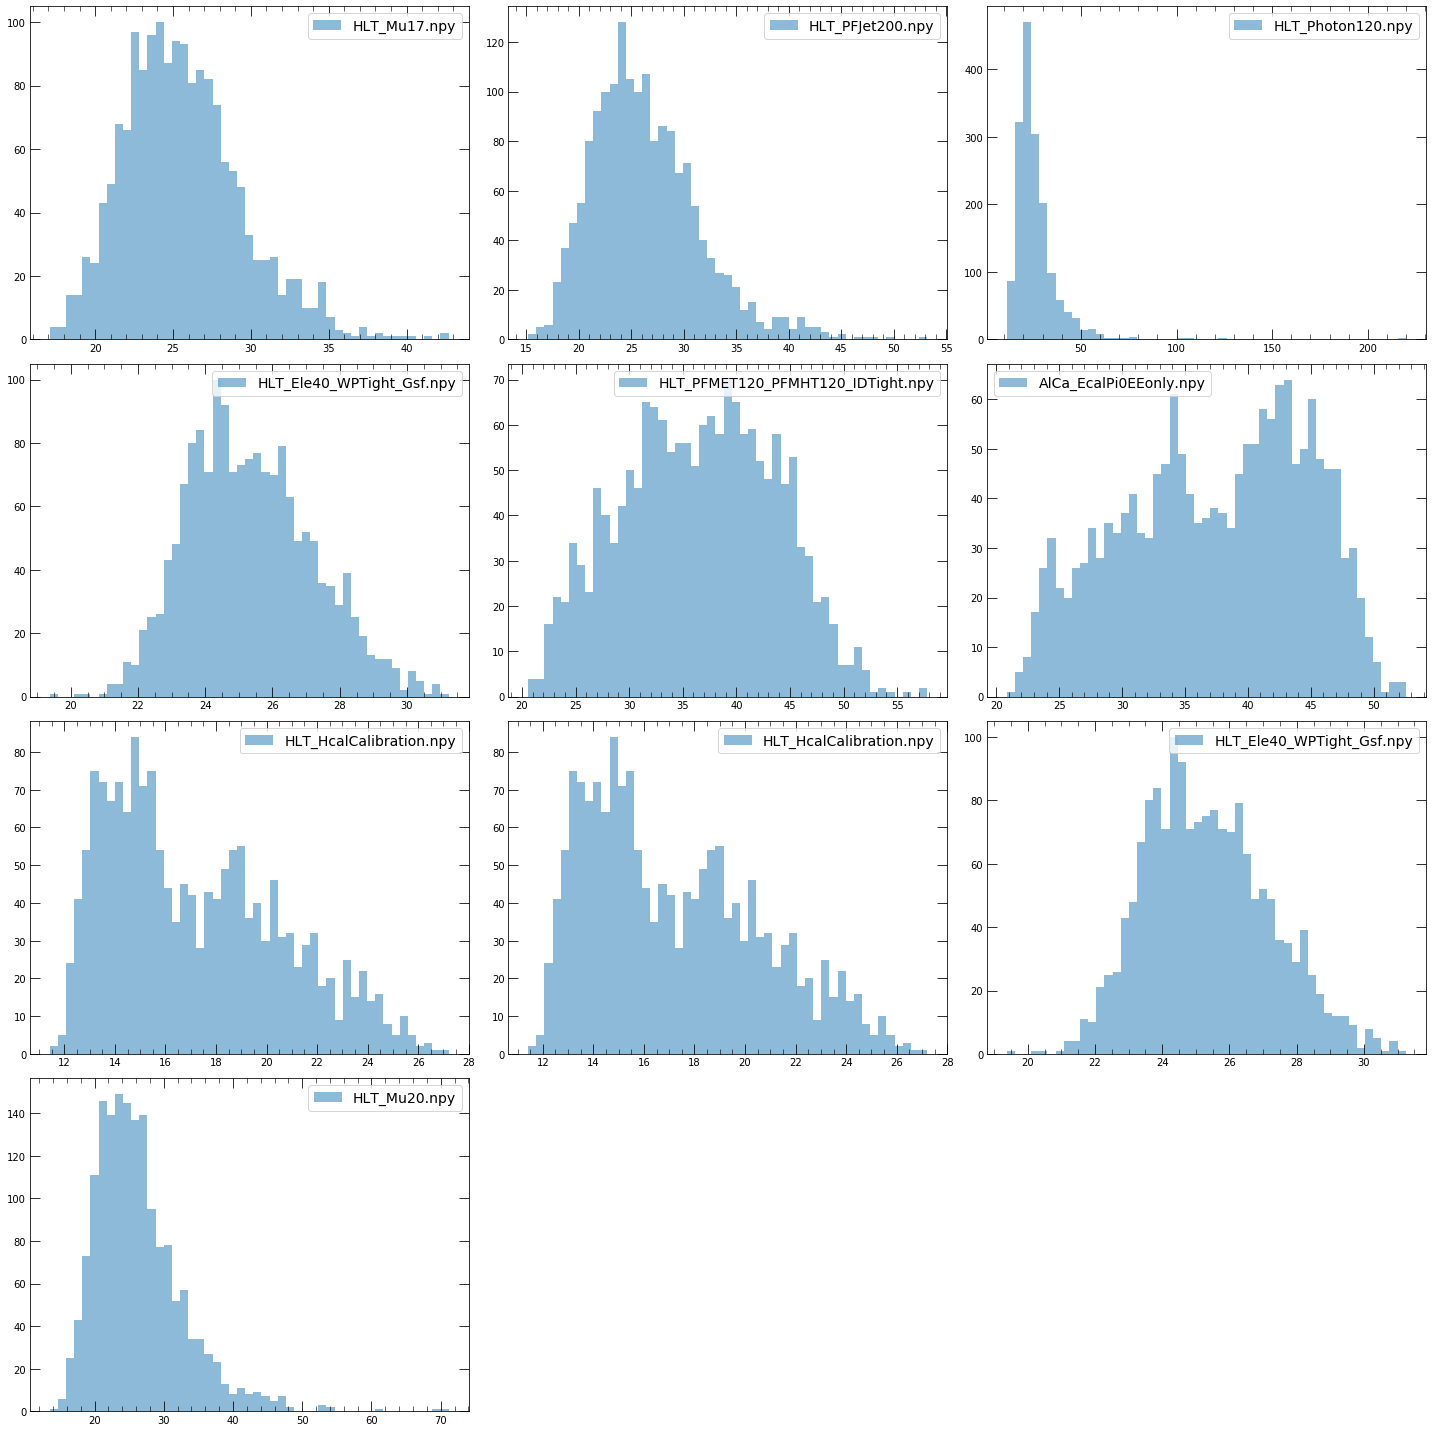

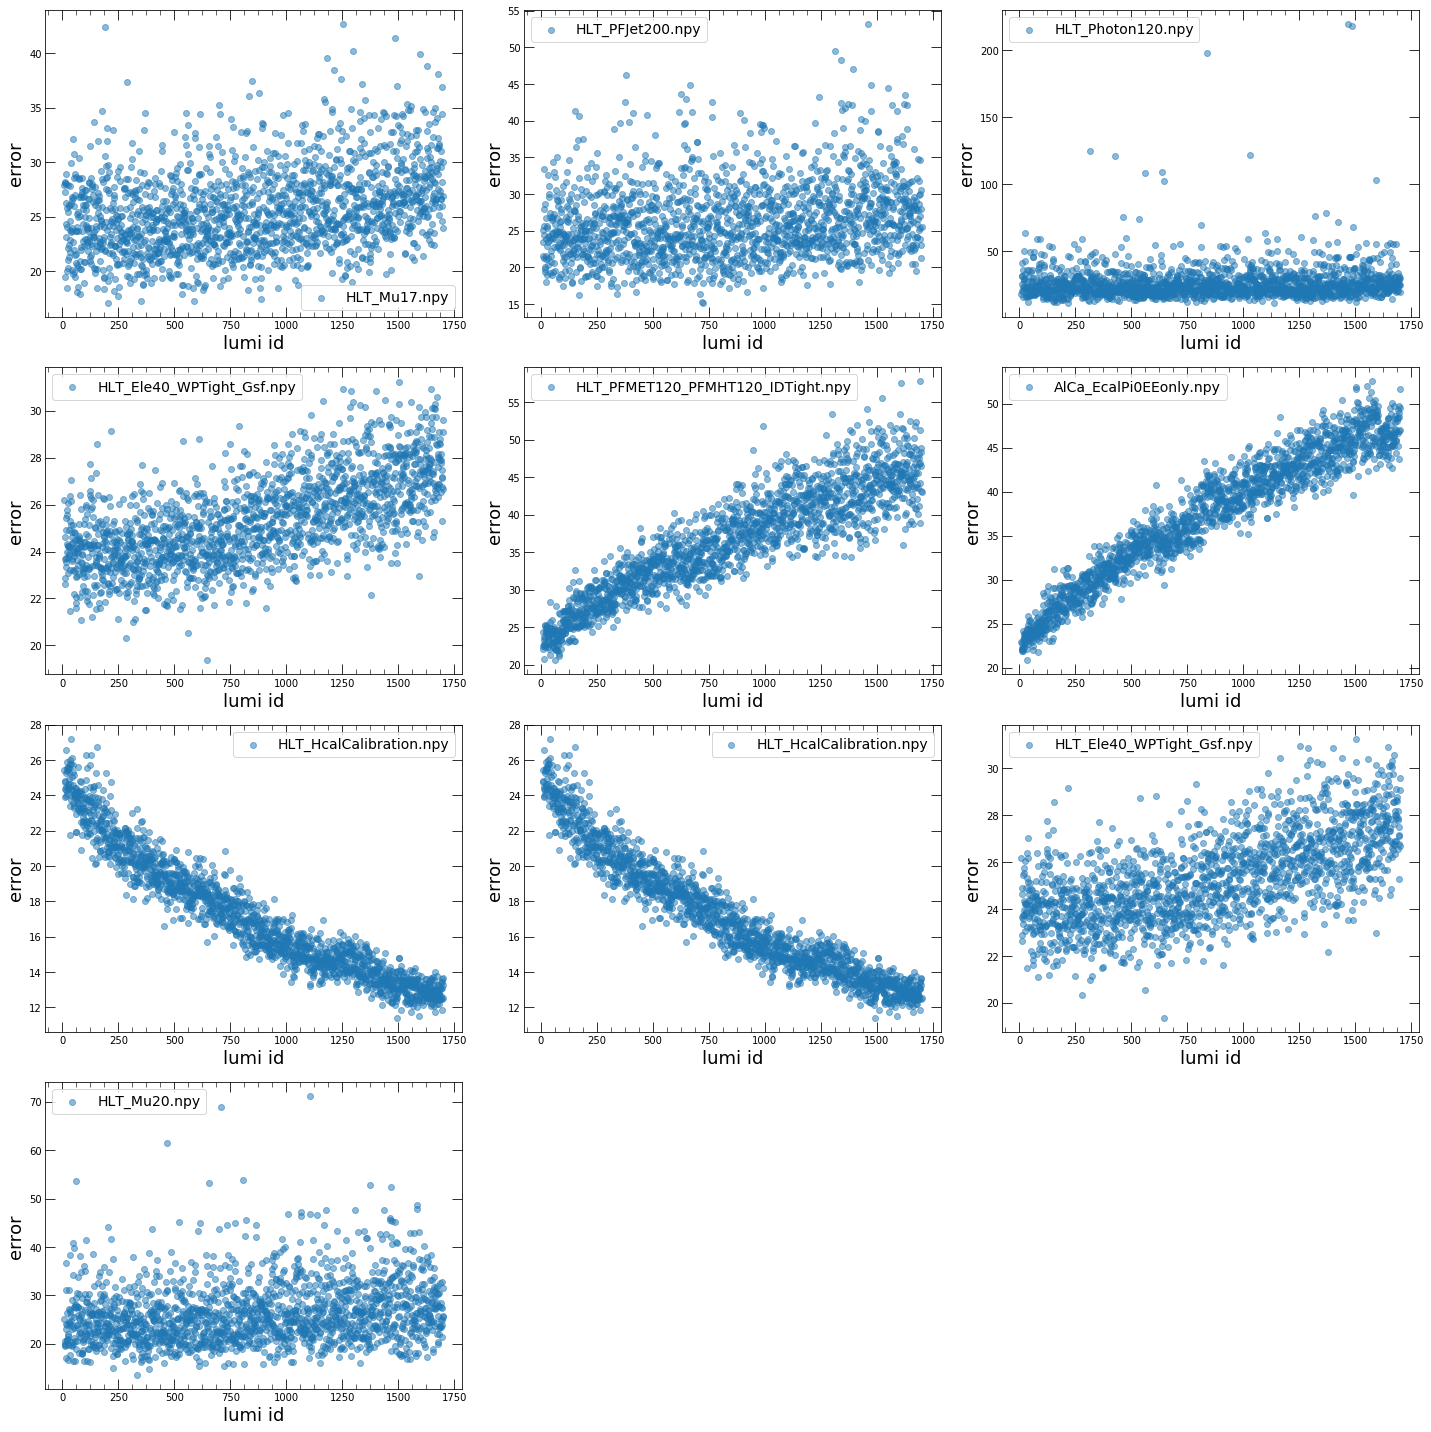

In [13]:
labels = data['HLT']
#bins = np.linspace(0,1,50)

bins  = 'auto'
plt.figure(figsize=fig_size)
for i in range(len(error_train_reformat)):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    bins = np.linspace(min(error_train_reformat[i]),max(error_train_reformat[i]),50)
    plt.hist(error_train_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi_train = np.linspace(0,len(error_train_reformat0]),len(error_train_reformat0]))
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(lumi_train,error_train_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()
plt.show()

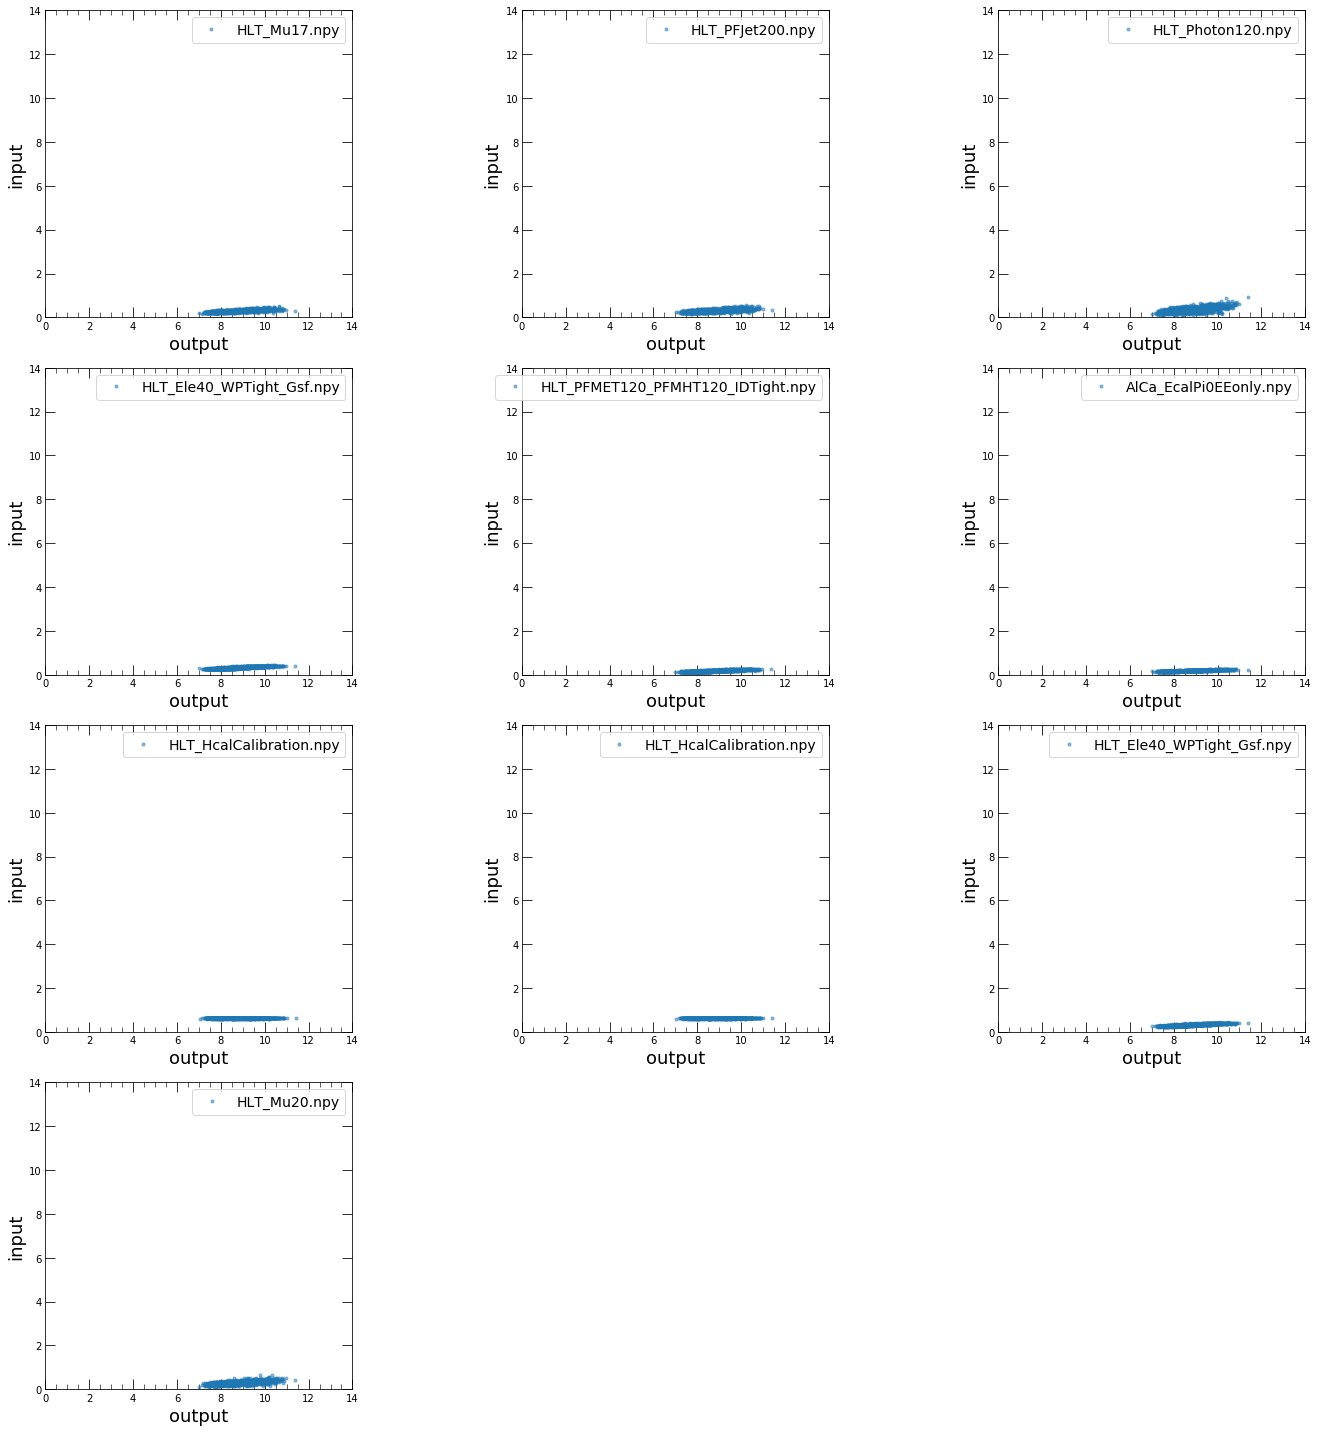

In [58]:
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi_train,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,14)
    plt.ylim(0,14)
    plt.legend() 
    
plt.tight_layout()
plt.show()

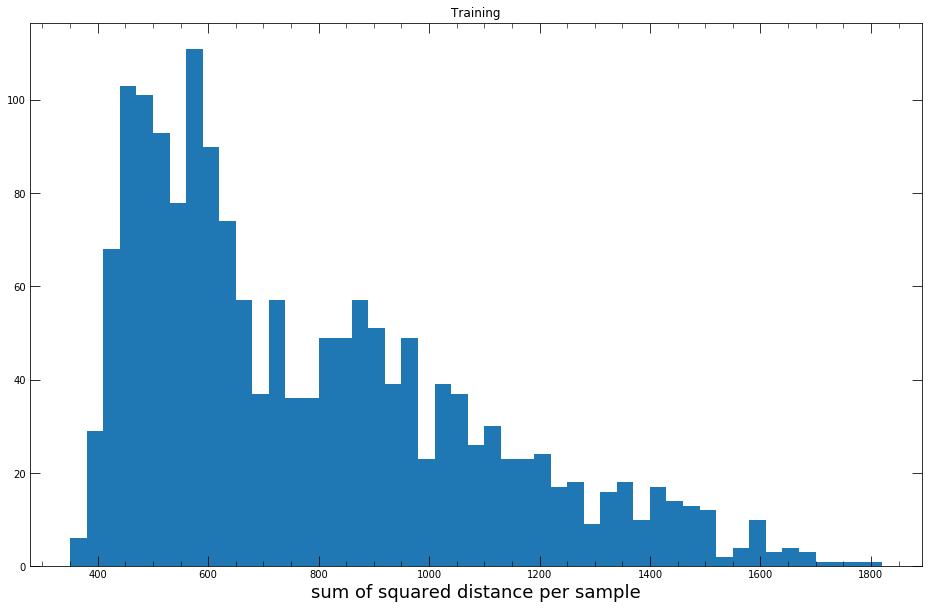

In [15]:
error_train = []
for r in range(len(reconstructed_train)):
    temp = 0
    for s in range(len(reconstructed_train[r])):
        temp+=(reconstructed_train[r][s]-x_train[r][s])**2
    error_train.append(temp)

bins = np.linspace(min(error_train),max(error_train),50)
plt.figure()
plt.hist(error_train,bins=bins)
plt.xlabel('sum of squared distance per sample')
plt.title('Training')
plt.show()

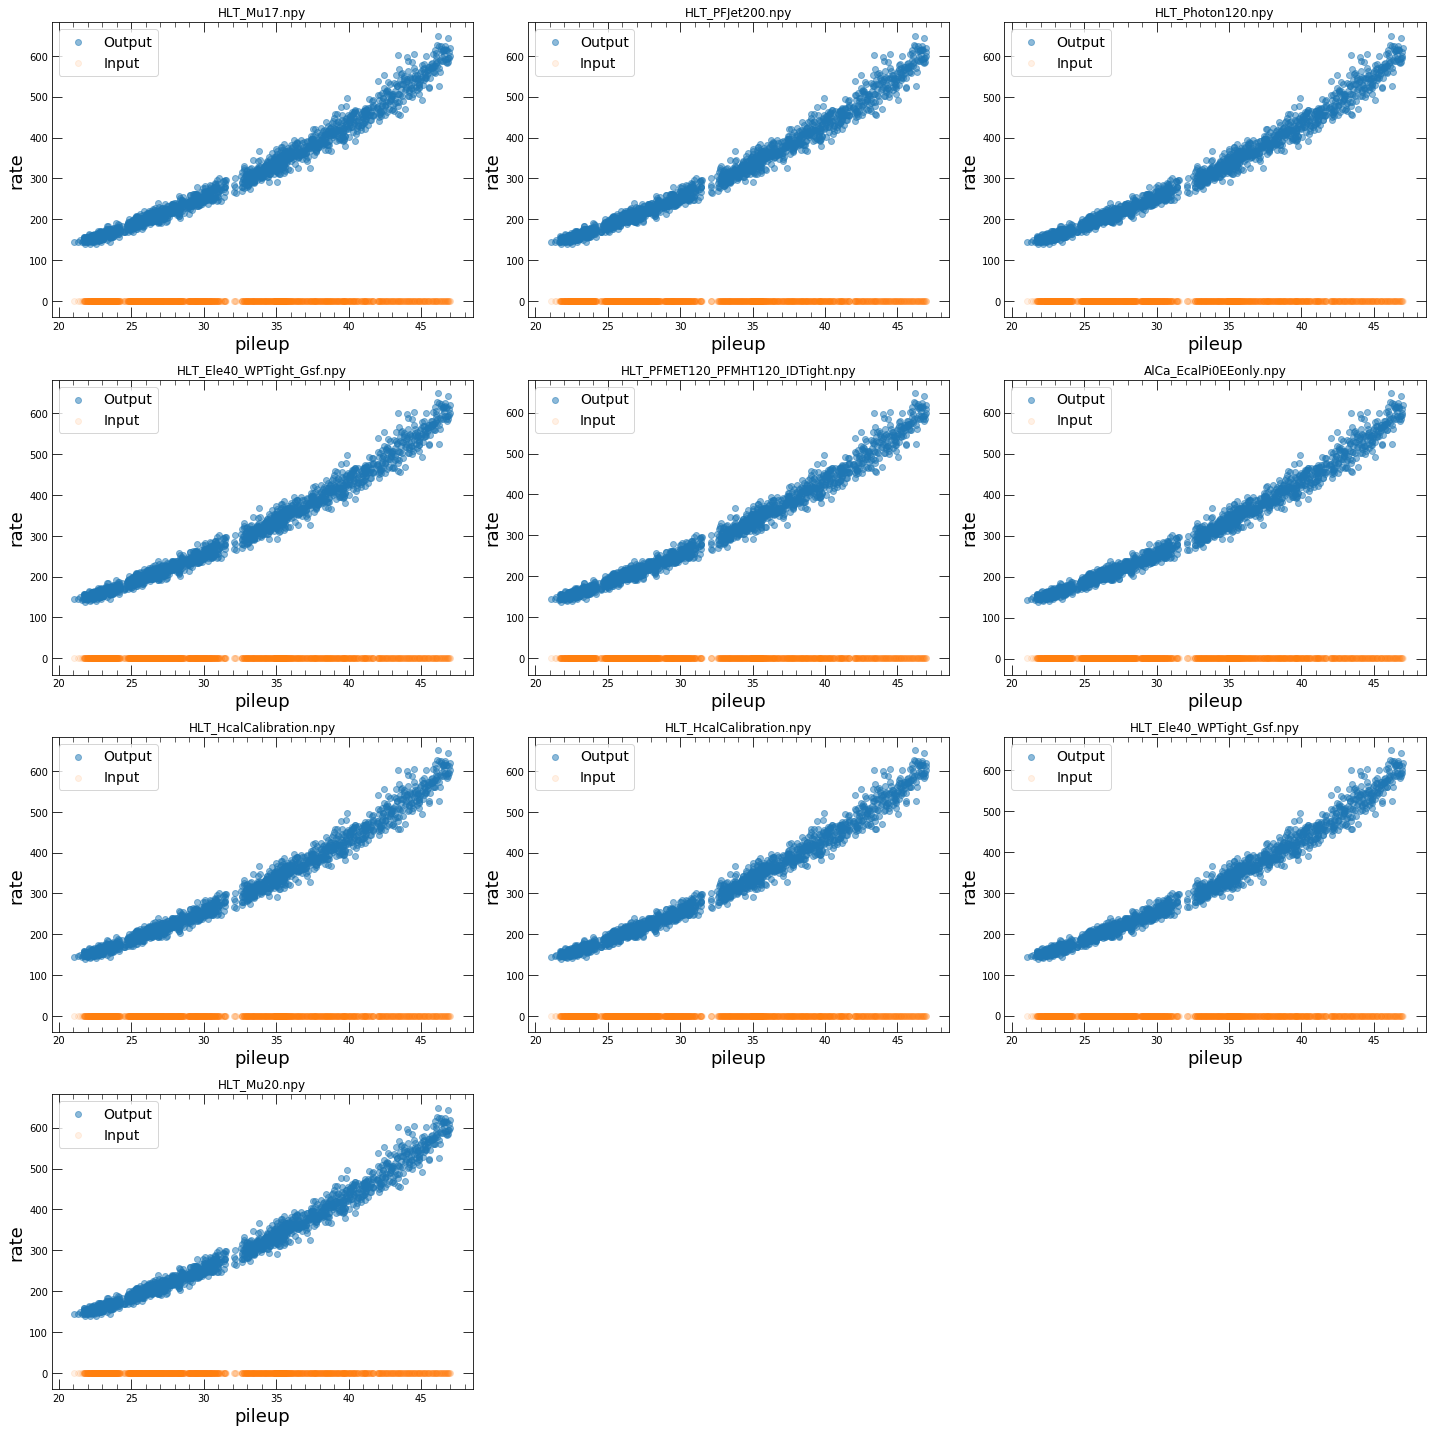

In [59]:
pileup_train = data[str(runs[0])]['pileup'][0]

output_rates = []
input_rates = data[str(runs[0])]['rates']

for r in range(num_rates):
    output_rates.append([])

for r in range(len(reconstructed_train)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_train[r][o]*pileup_train[r])
    
plt.figure(figsize=fig_size)
              
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(pileup_train,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_train,input_rates[i],label='Input',alpha=.1)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Test Data

In [17]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

reconstructed_test = model.predict(np.array(x_test))

error = abs(x_test-reconstructed_test)/x_test

In [18]:
error_test_reformat = []
inp = []
outp = []
for i in range(num_rates):
    error_test_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    #print(len(error_test_reformat[0]))
    for j in range(num_rates):
        error_test_reformat[j].append(error[i][j])
        outp[j].append(reconstructed_test[i][j])
        inp[j].append(x_test[i][j])

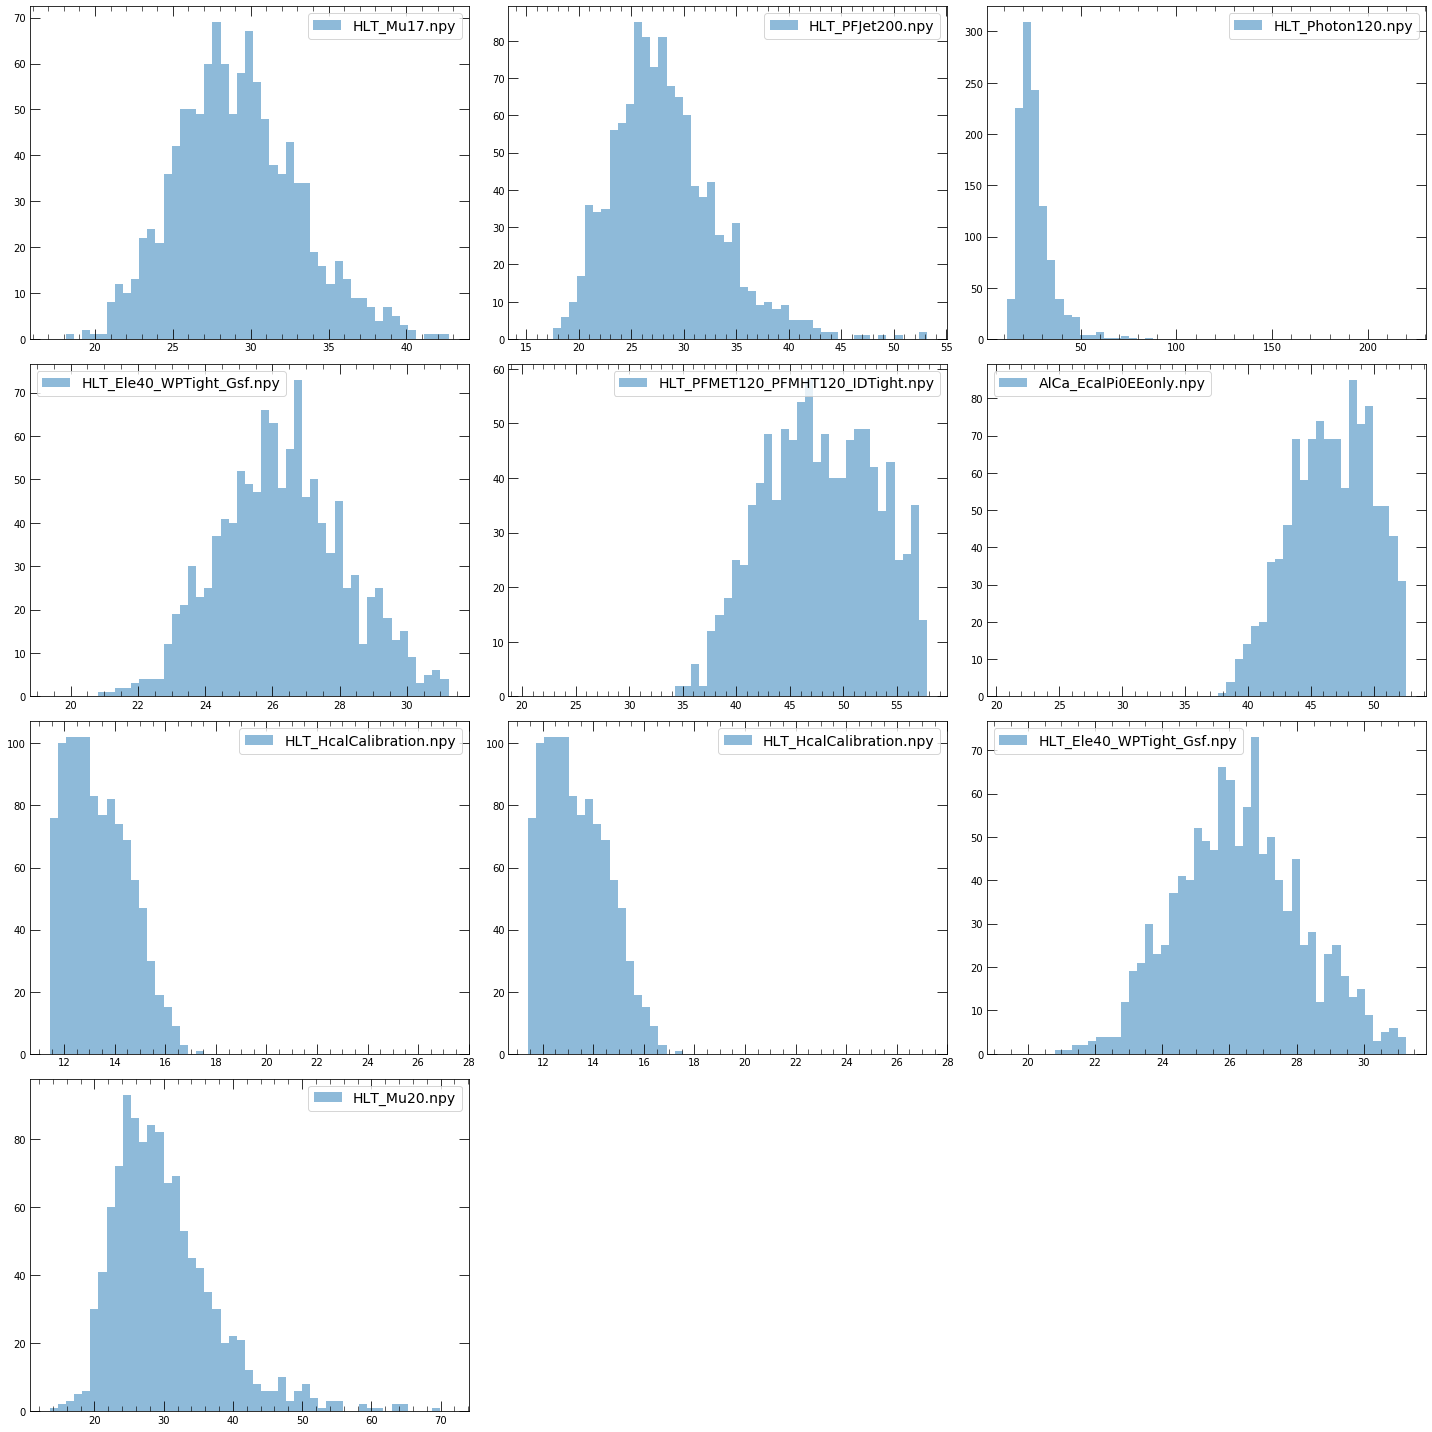

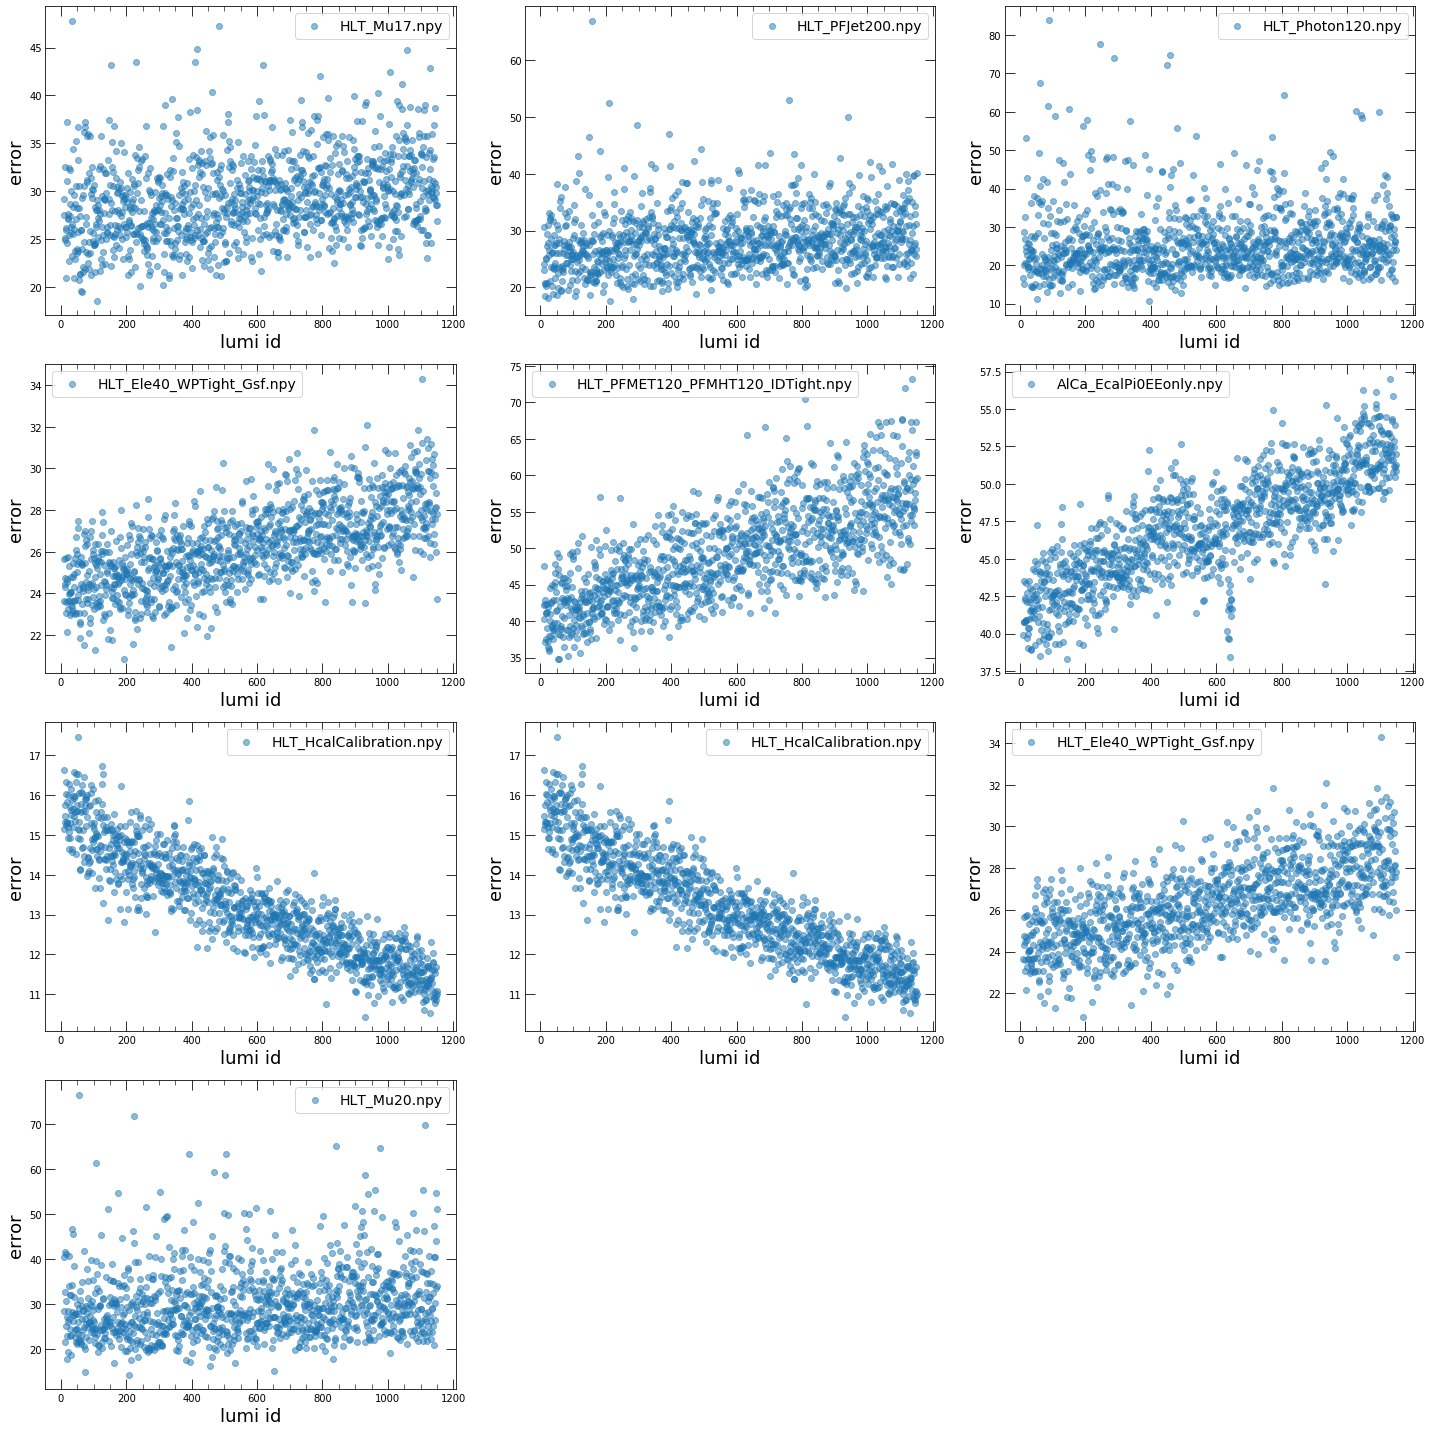

In [19]:
#bins = np.linspace(0,1,50)
plt.figure(figsize=fig_size)
for i in range(len(error_test_reformat)):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    bins = np.linspace(min(error_train_reformat[i]),max(error_train_reformat[i]),50)
    plt.hist(error_test_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi_test = data[str(runs[2])]['lumiid']
#lumi_test = np.linspace(0,len(error_test_reformat[0]),len(error_test_reformat[0]))
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()
plt.show()

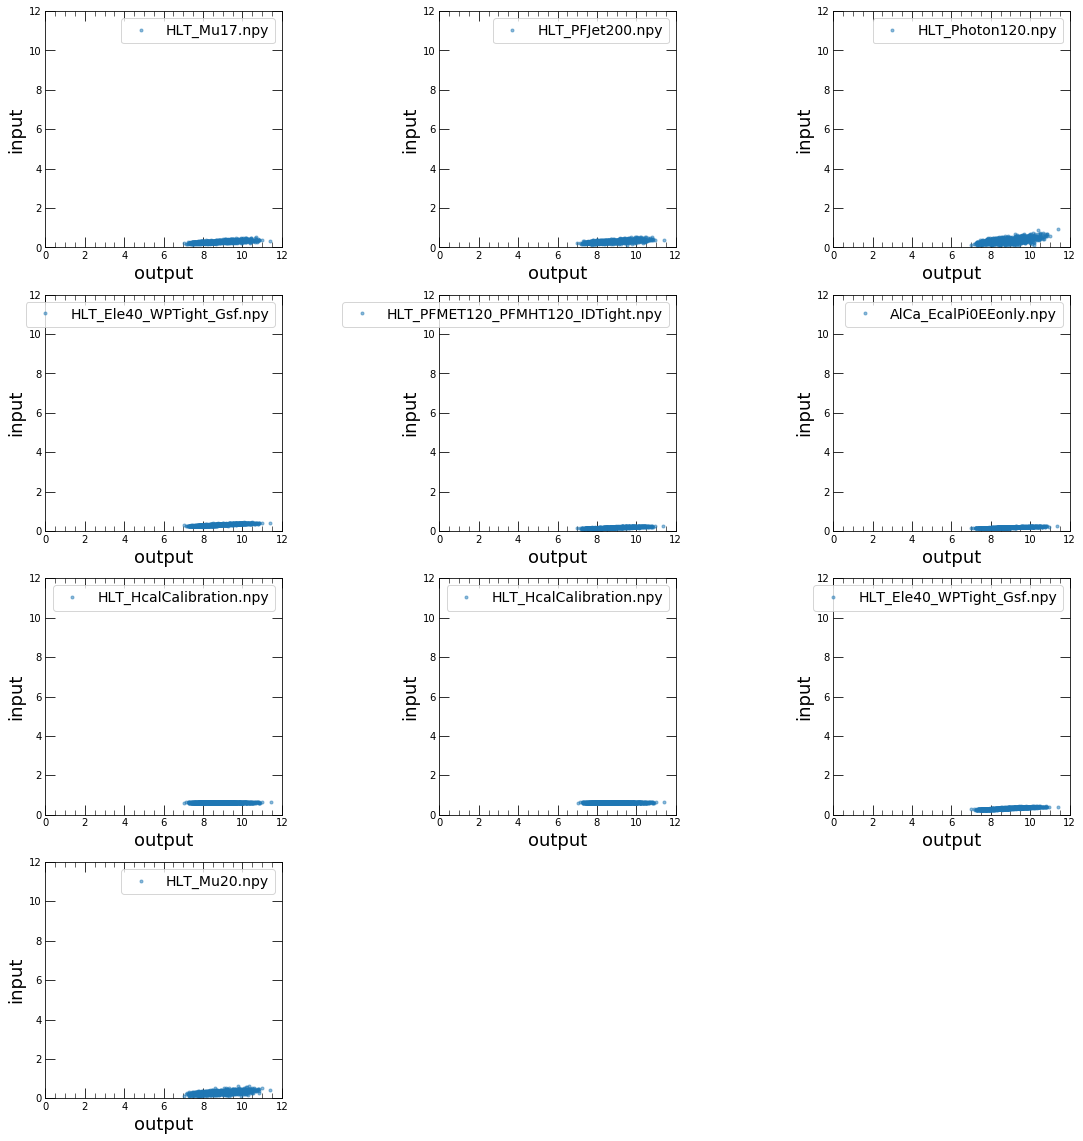

In [56]:
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi_test,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,12)
    plt.ylim(0,12)
    plt.legend()    

plt.show()

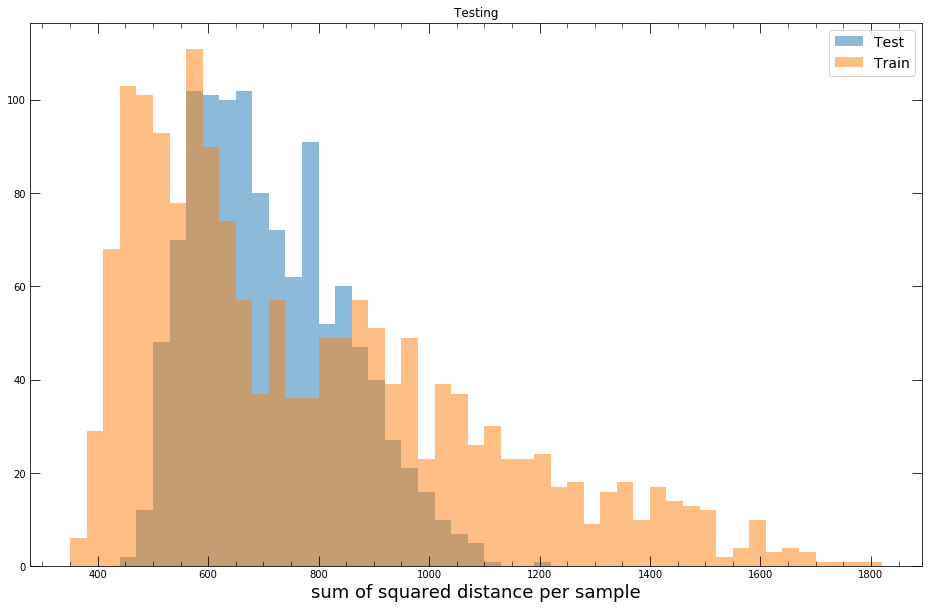

In [21]:
error_test = []
for r in range(len(reconstructed_test)):
    temp = 0
    for s in range(len(reconstructed_test[r])):
        temp+=(reconstructed_test[r][s]-x_test[r][s])**2
    error_test.append(temp)

plt.figure()
bins = np.linspace(min(error_train),max(error_train),50)
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.legend()
plt.xlabel('sum of squared distance per sample')
plt.title('Testing')
plt.show()

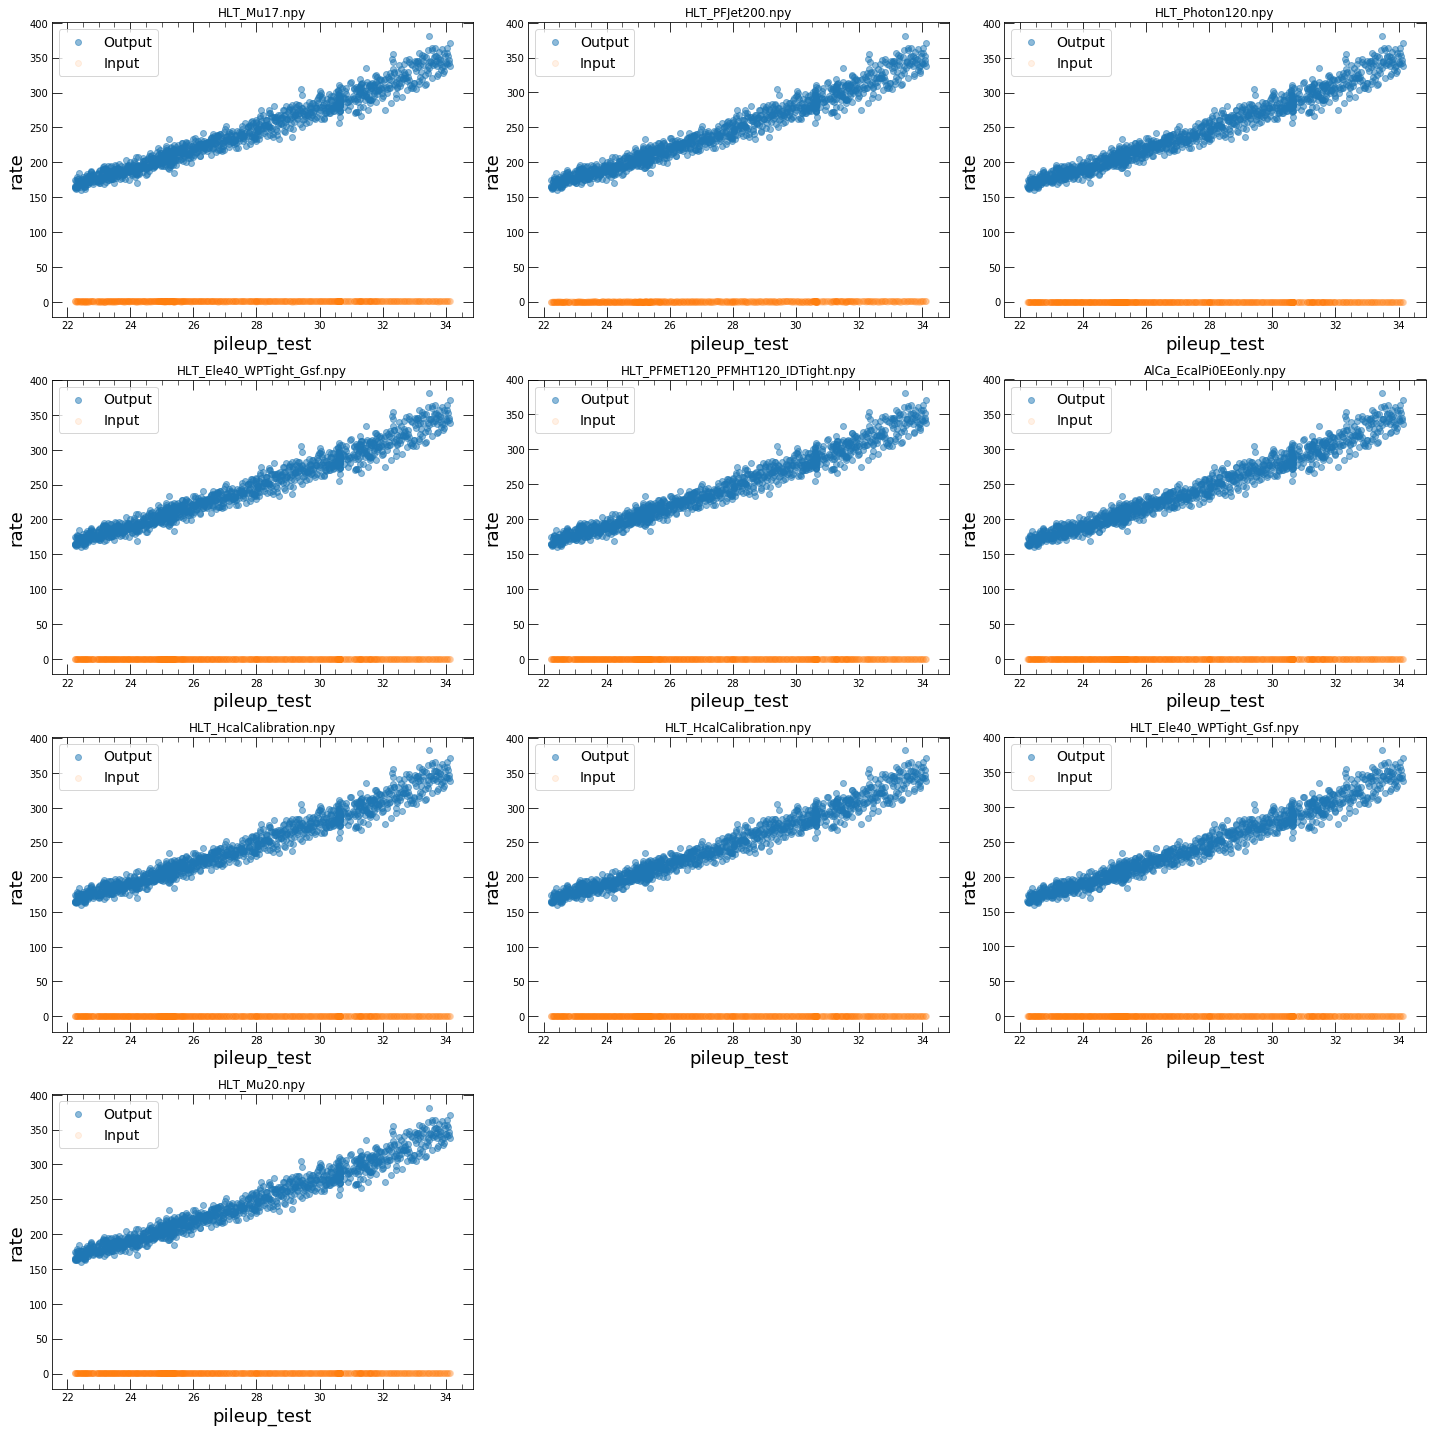

In [57]:
pileup_test = data[str(runs[2])]['pileup'][0]

output_rates = []
input_rates = data[str(runs[2])]['rates']

for r in range(num_rates):
    output_rates.append([])

for r in range(len(reconstructed_test)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_test[r][o]*pileup_test[r])
    
plt.figure(figsize=fig_size)
              
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(pileup_test,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_test,input_rates[i],label='Input',alpha=.1)
    plt.xlabel('pileup_test')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Fake Bad Data

In [23]:
one_bad = np.array(data[str(runs[2])]['bad_samples'])

In [24]:
reconstructed_one_bad = model.predict(np.array(one_bad))

error_one_bad = abs(one_bad-reconstructed_one_bad)/one_bad

In [25]:
error_reformat_one_bad = []
inp_one_bad = []
outp_one_bad = []
for i in range(num_rates):
    error_reformat_one_bad.append([])
    inp_one_bad.append([])
    outp_one_bad.append([])

for i in range(len(error_one_bad)):
    for j in range(num_rates):
        error_reformat_one_bad[j].append(error_one_bad[i][j])
        outp_one_bad[j].append(reconstructed_one_bad[i][j])
        inp_one_bad[j].append(one_bad[i][j])
            
        

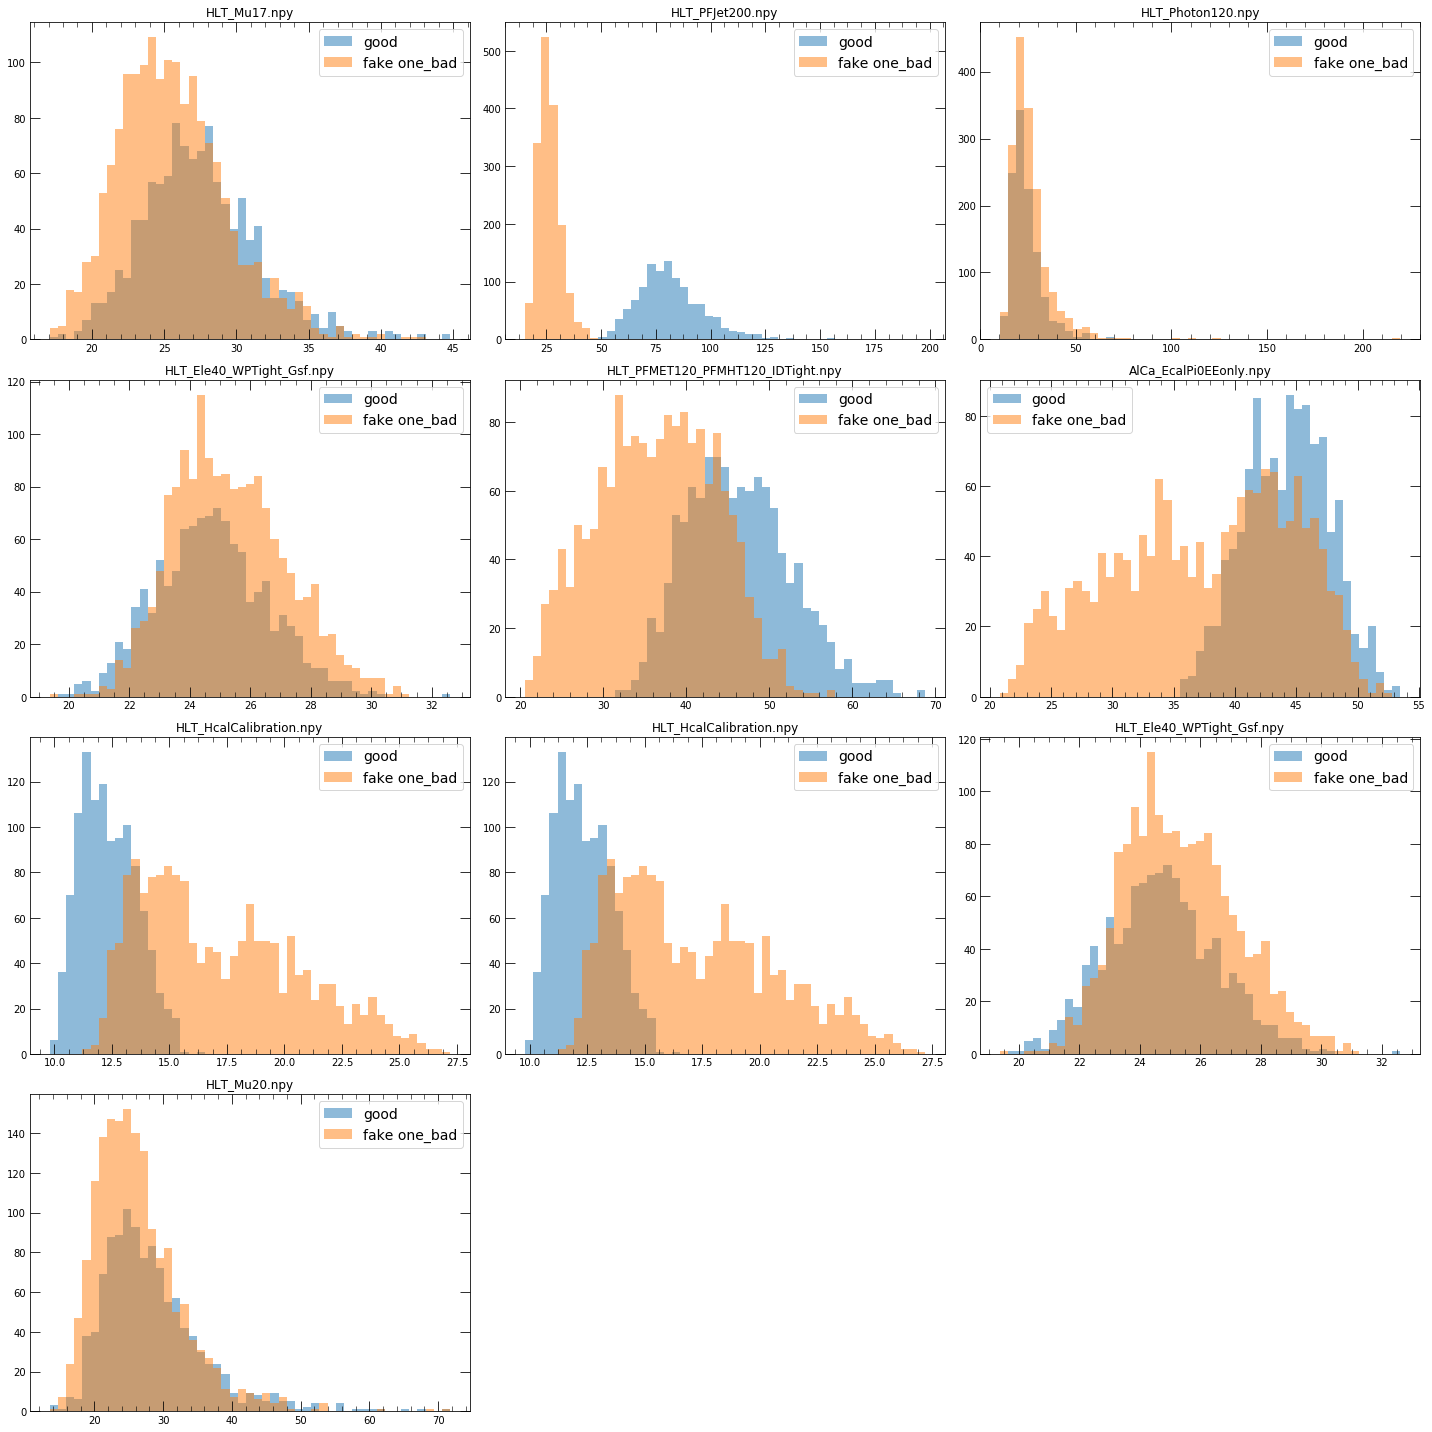

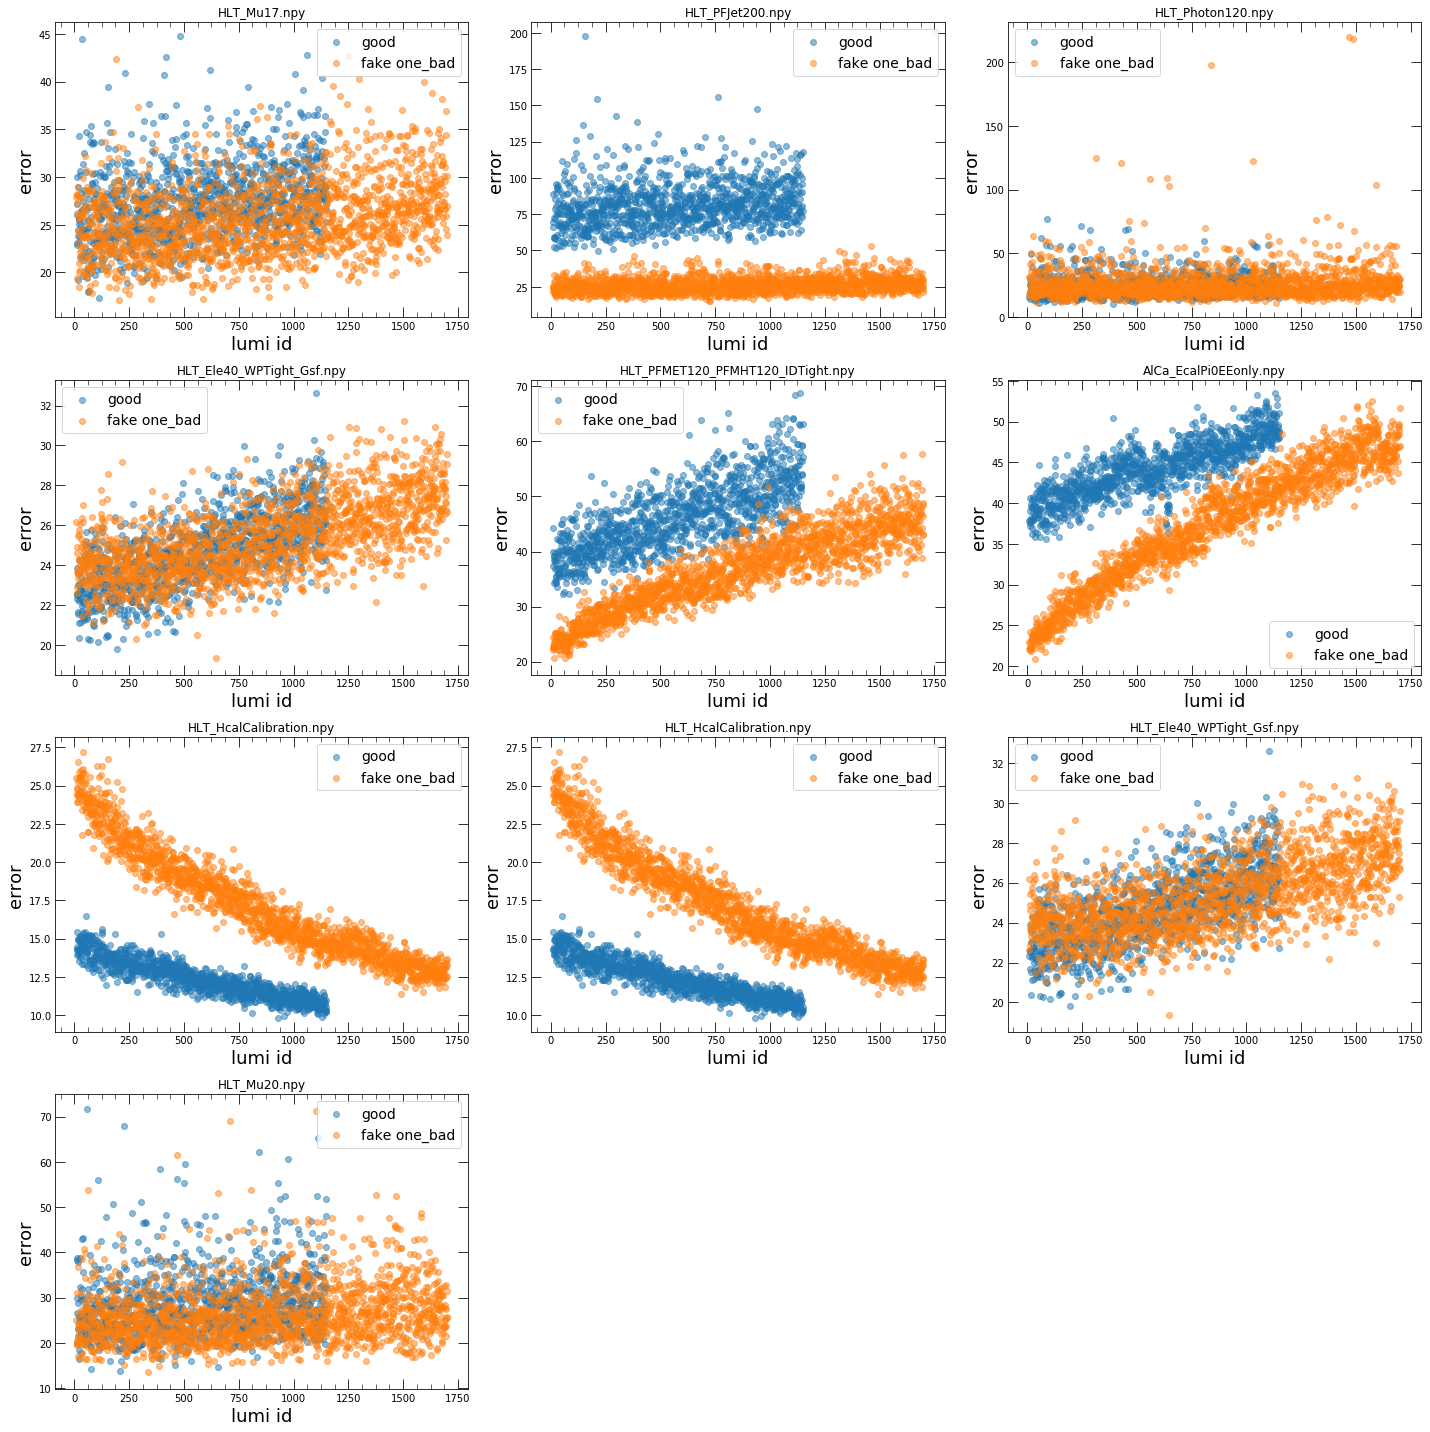

In [26]:
#bins = np.linspace(0,1,50)
bins  = 'auto'
plt.figure(figsize=fig_size)
for i in range(len(error_reformat_one_bad)):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    bins = np.linspace(min(min(error_train_reformat[i]),min(error_reformat_one_bad[i])),max(max(error_train_reformat[i]),max(error_reformat_one_bad[i])),50)
    plt.hist(error_reformat_one_bad[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_train_reformat[i],bins=bins,label='fake one_bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi_one_bad = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_one_bad[0]),len(error_reformat_one_bad0]),len(lumi_one_bad))
#lumi_one_bad = np.linspace(0,len(error_reformat_one_bad[0]),len(error_reformat_one_bad[0]))
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(lumi_one_bad,error_reformat_one_bad[i],label = 'good', alpha =.5)
    plt.scatter(lumi_train,error_train_reformat[i],label='fake one_bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

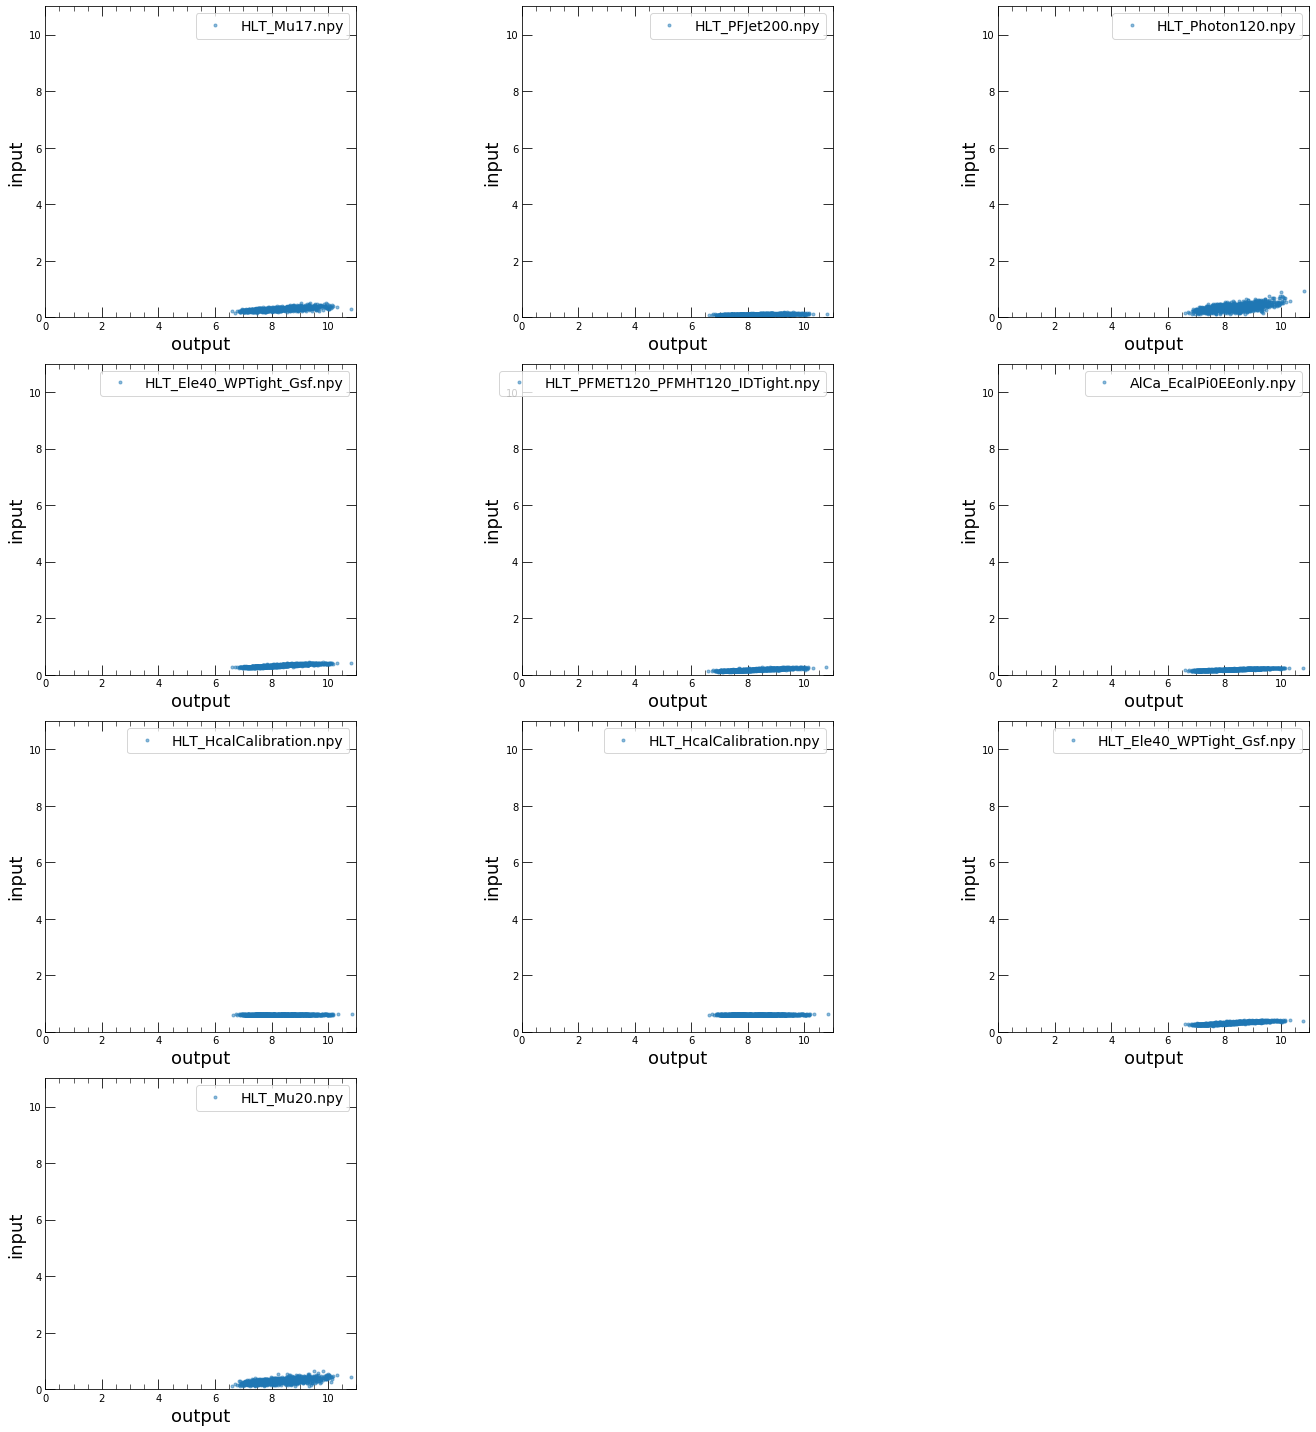

In [60]:
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.plot(outp_one_bad[i],inp_one_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,11)
    plt.ylim(0,11)
    plt.legend()    
plt.tight_layout()
plt.show()

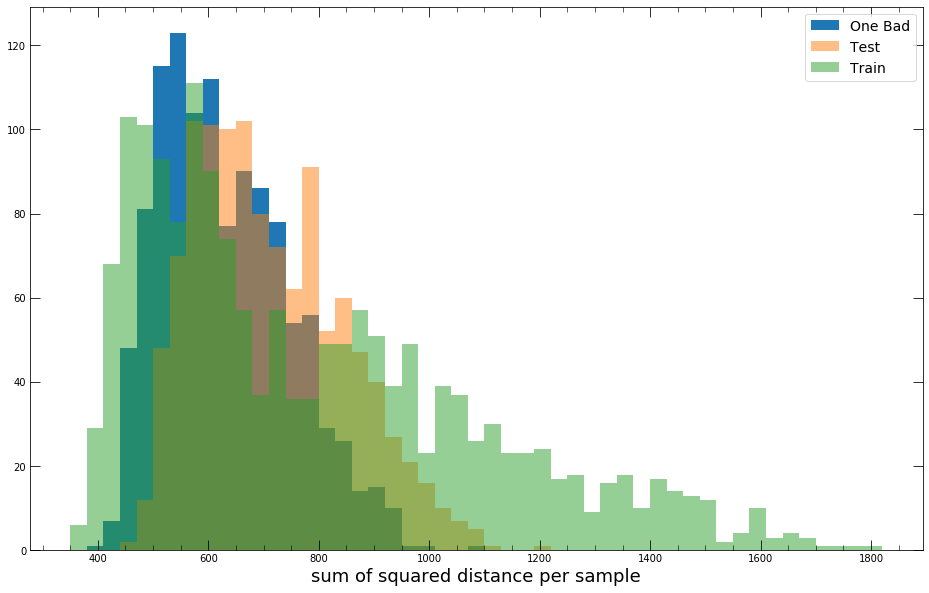

In [28]:
error_one_bad = []
for r in range(len(reconstructed_one_bad)):
    temp = 0
    for s in range(len(reconstructed_one_bad[r])):
        temp+=(reconstructed_one_bad[r][s]-one_bad[r][s])**2
    error_one_bad.append(temp)

plt.figure()
bins = np.linspace(min(min(error_train),min(error_one_bad),min(error_test)),max(max(error_train),max(error_test),max(error_one_bad)),50)
plt.hist(error_one_bad,bins=bins,label="One Bad")
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.legend()
plt.xlabel('sum of squared distance per sample')
plt.show()

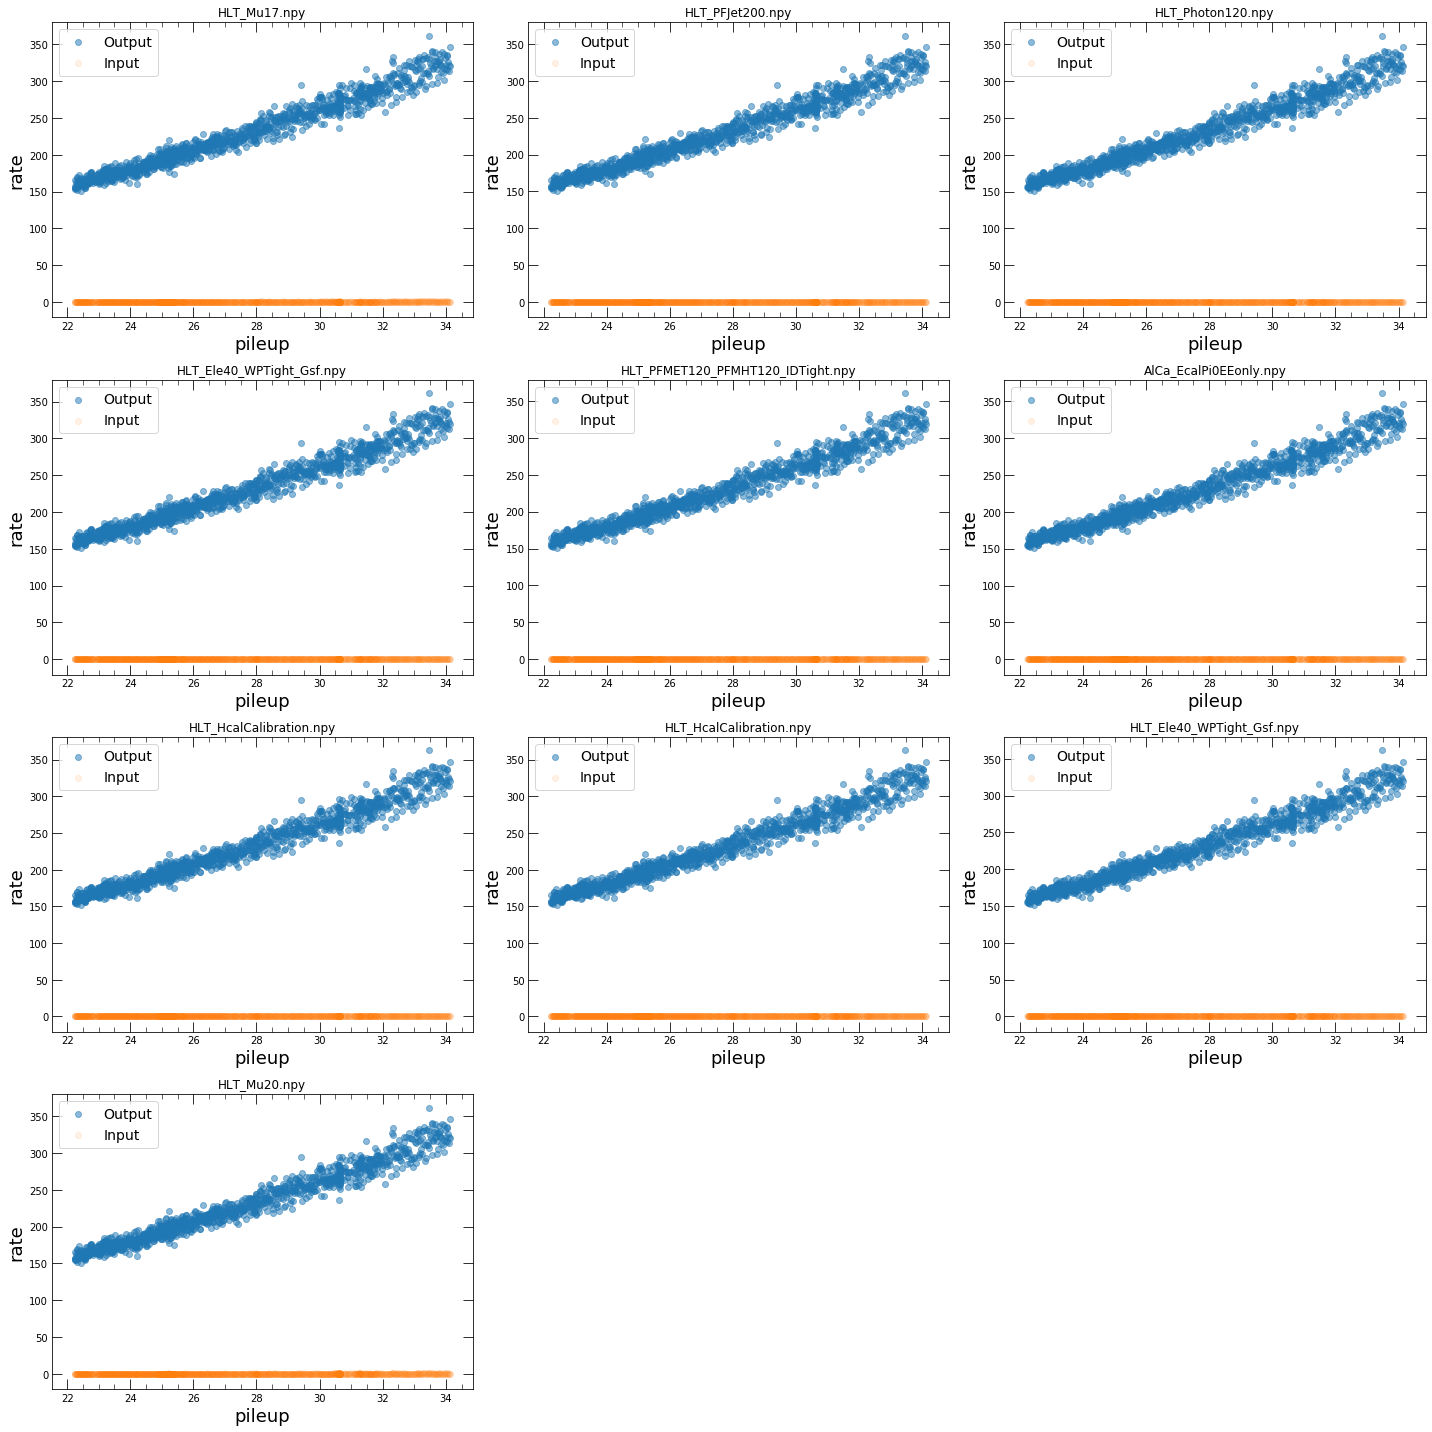

In [62]:
pileup_one_bad = data[str(runs[2])]['pileup'][0]

output_rates = []
input_rates = data[str(runs[2])]['rates']
input_rates[1] = np.array(input_rates[1])/3

for r in range(num_rates):
    output_rates.append([])

for r in range(len(reconstructed_one_bad)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_one_bad[r][o]*pileup_one_bad[r])
    
plt.figure(figsize=fig_size)
              
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(pileup_one_bad,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_one_bad,input_rates[i],label='Input',alpha=.1)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Fake Bad Data - ALL

In [30]:
all_bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [31]:
reconstructed_all_bad = model.predict(np.array(all_bad))

error_all_bad = abs(all_bad-reconstructed_all_bad)/all_bad

In [32]:
error_reformat_all_bad = []
inp_all_bad = []
outp_all_bad = []
for i in range(num_rates):
    error_reformat_all_bad.append([])
    inp_all_bad.append([])
    outp_all_bad.append([])

for i in range(len(error_all_bad)):
    for j in range(num_rates):
        error_reformat_all_bad[j].append(error_all_bad[i][j])
        outp_all_bad[j].append(reconstructed_all_bad[i][j])
        inp_all_bad[j].append(all_bad[i][j])
            
        

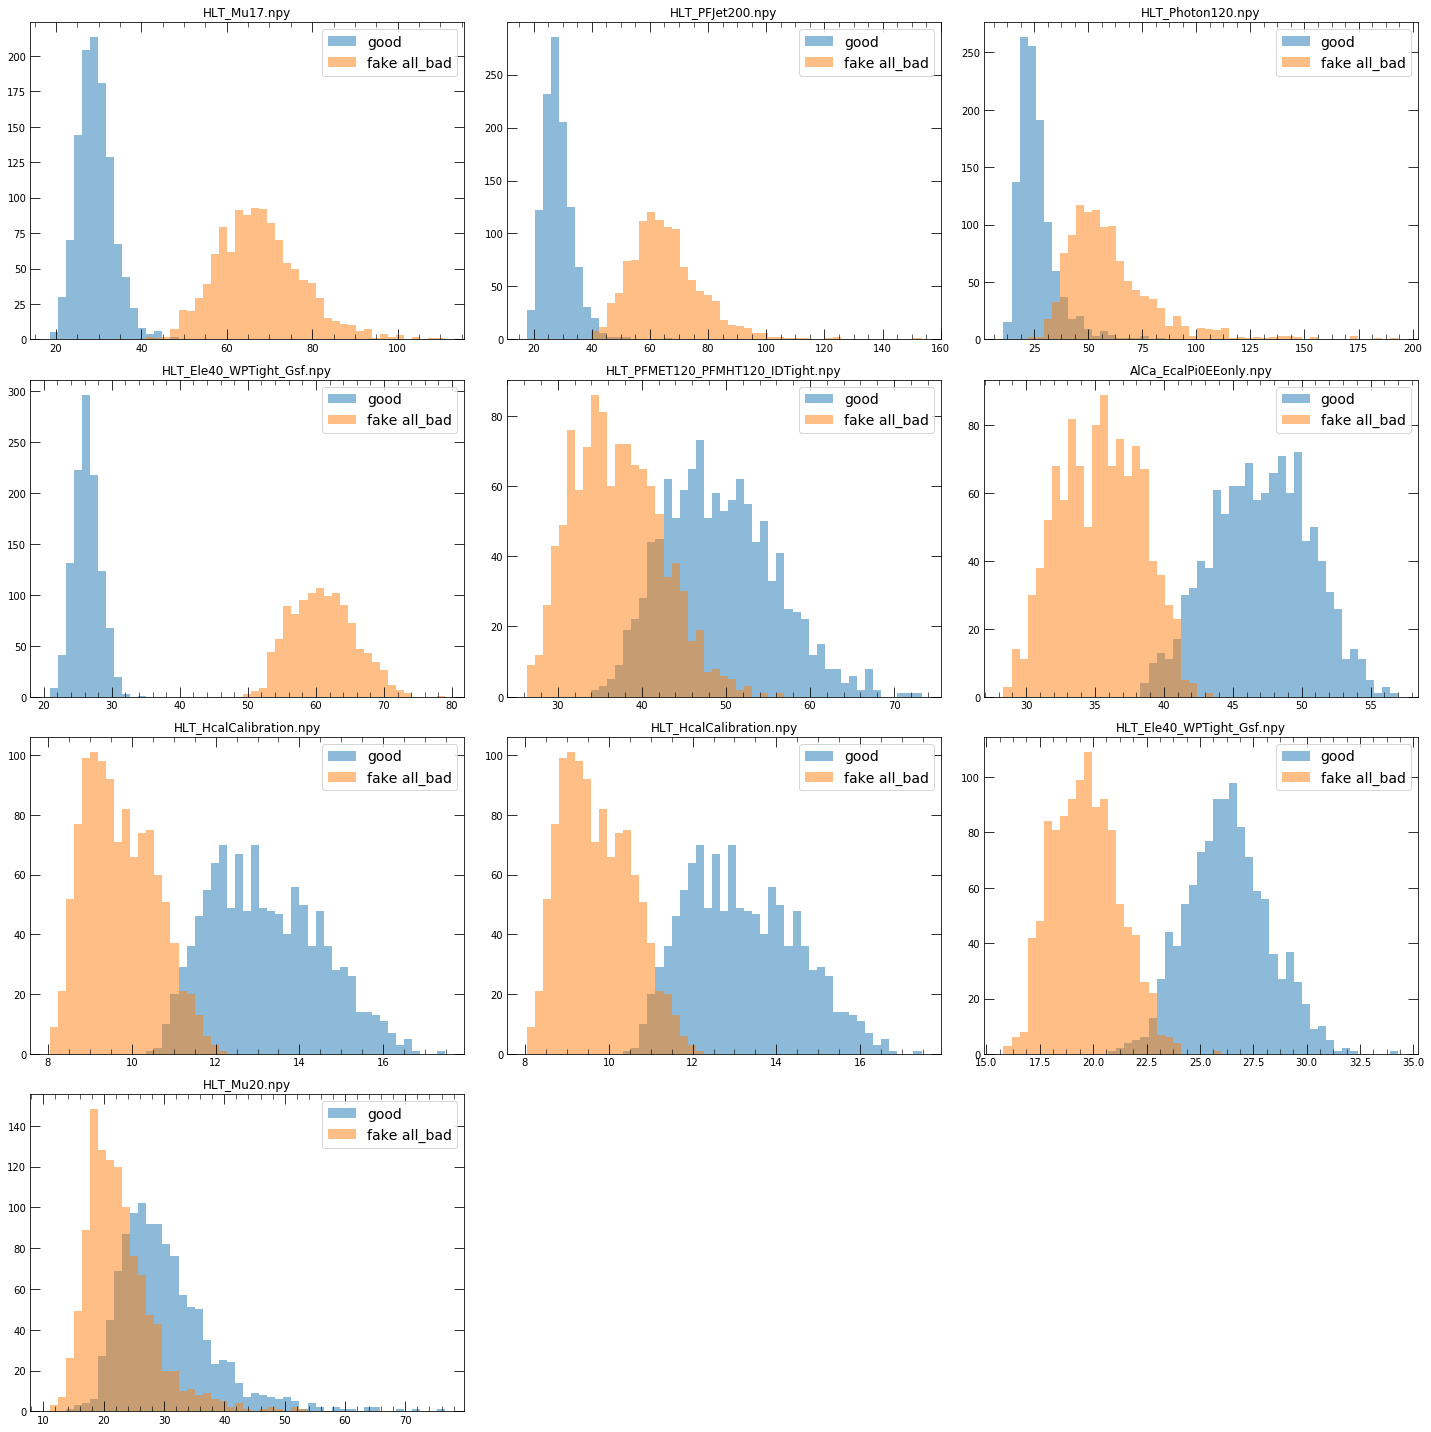

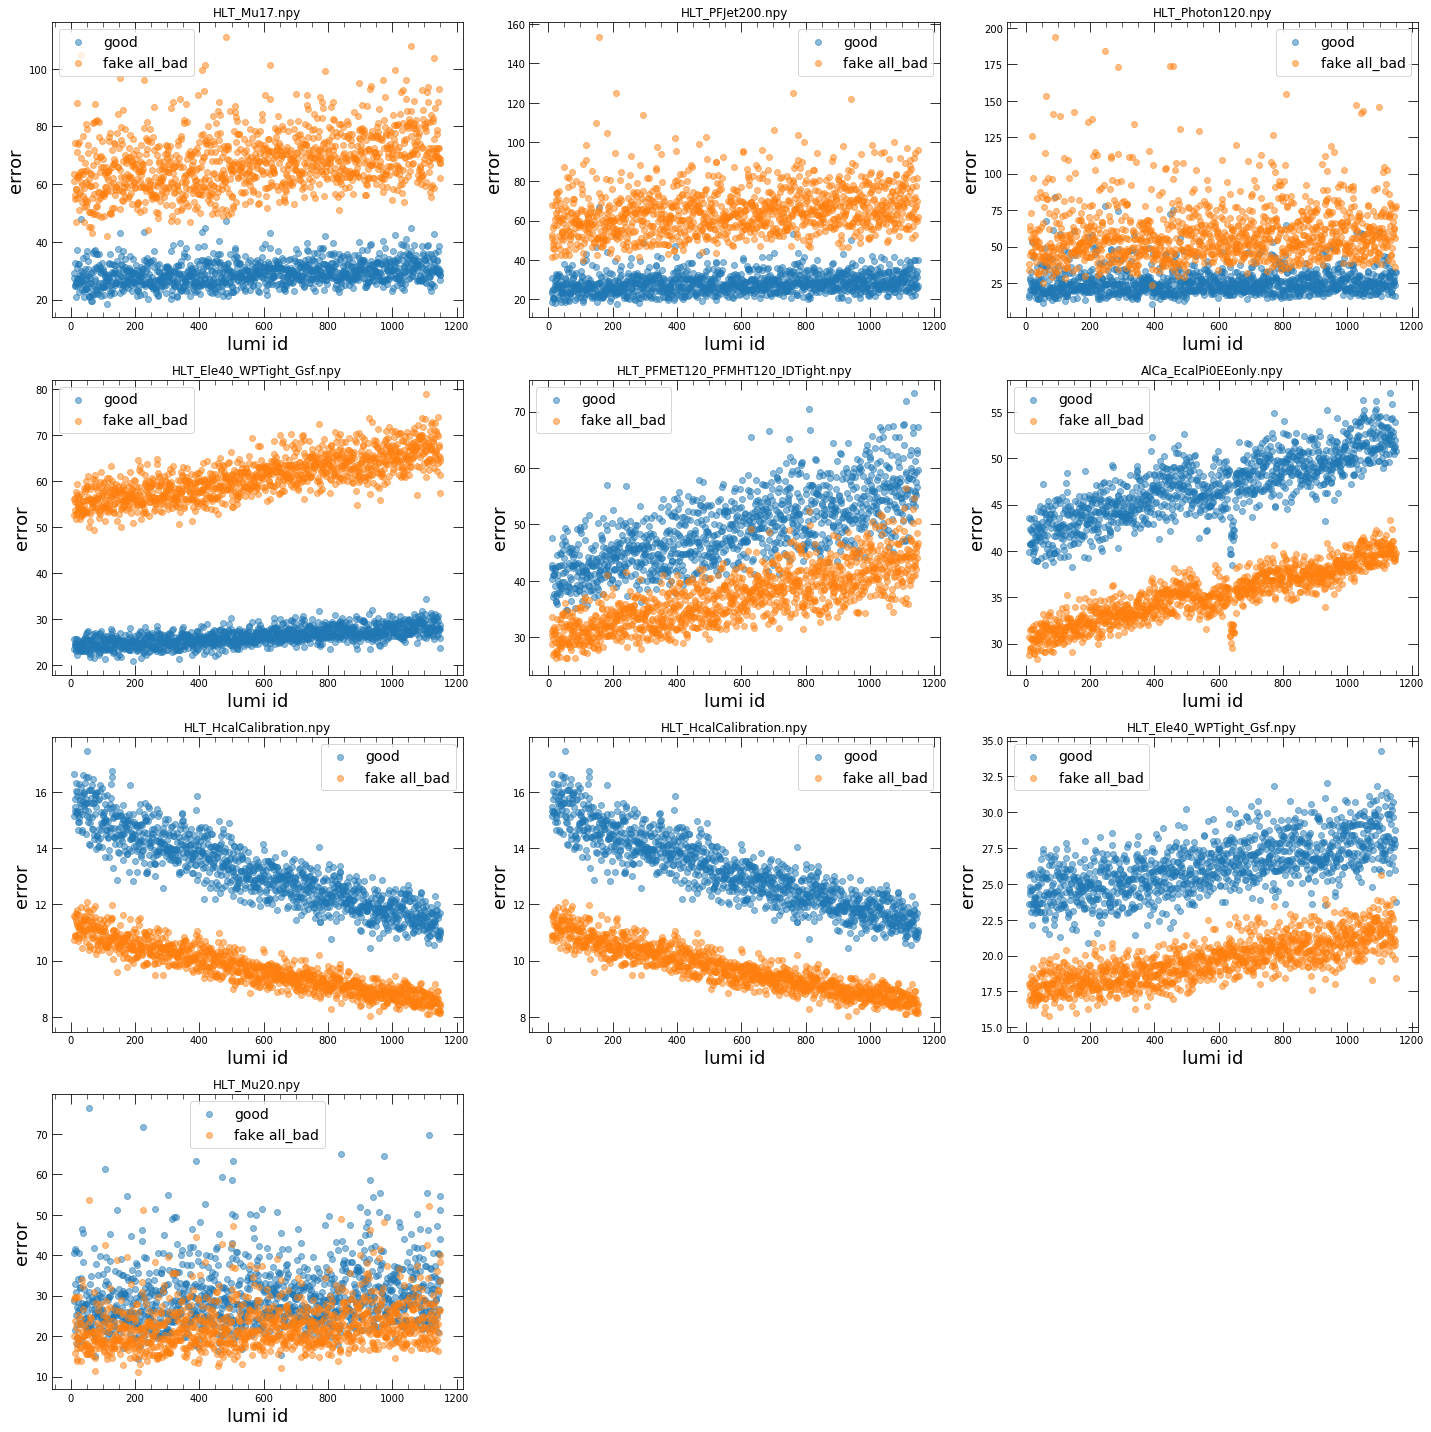

In [33]:
#bins = np.linspace(0,1,50)
bins  = 'auto'
plt.figure(figsize=fig_size)
for i in range(len(error_reformat_all_bad)):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_all_bad[i])),max(max(error_test_reformat[i]),max(error_reformat_all_bad[i])),50)
    plt.hist(error_test_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_all_bad[i],bins=bins,label='fake all_bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi_all_bad = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_all_bad[0]),len(error_test_reformat0]),len(lumi_all_bad))
#lumi_all_bad = np.linspace(0,len(error_reformat_all_bad[0]),len(error_reformat_all_bad[0]))
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi_all_bad,error_reformat_all_bad[i],label='fake all_bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

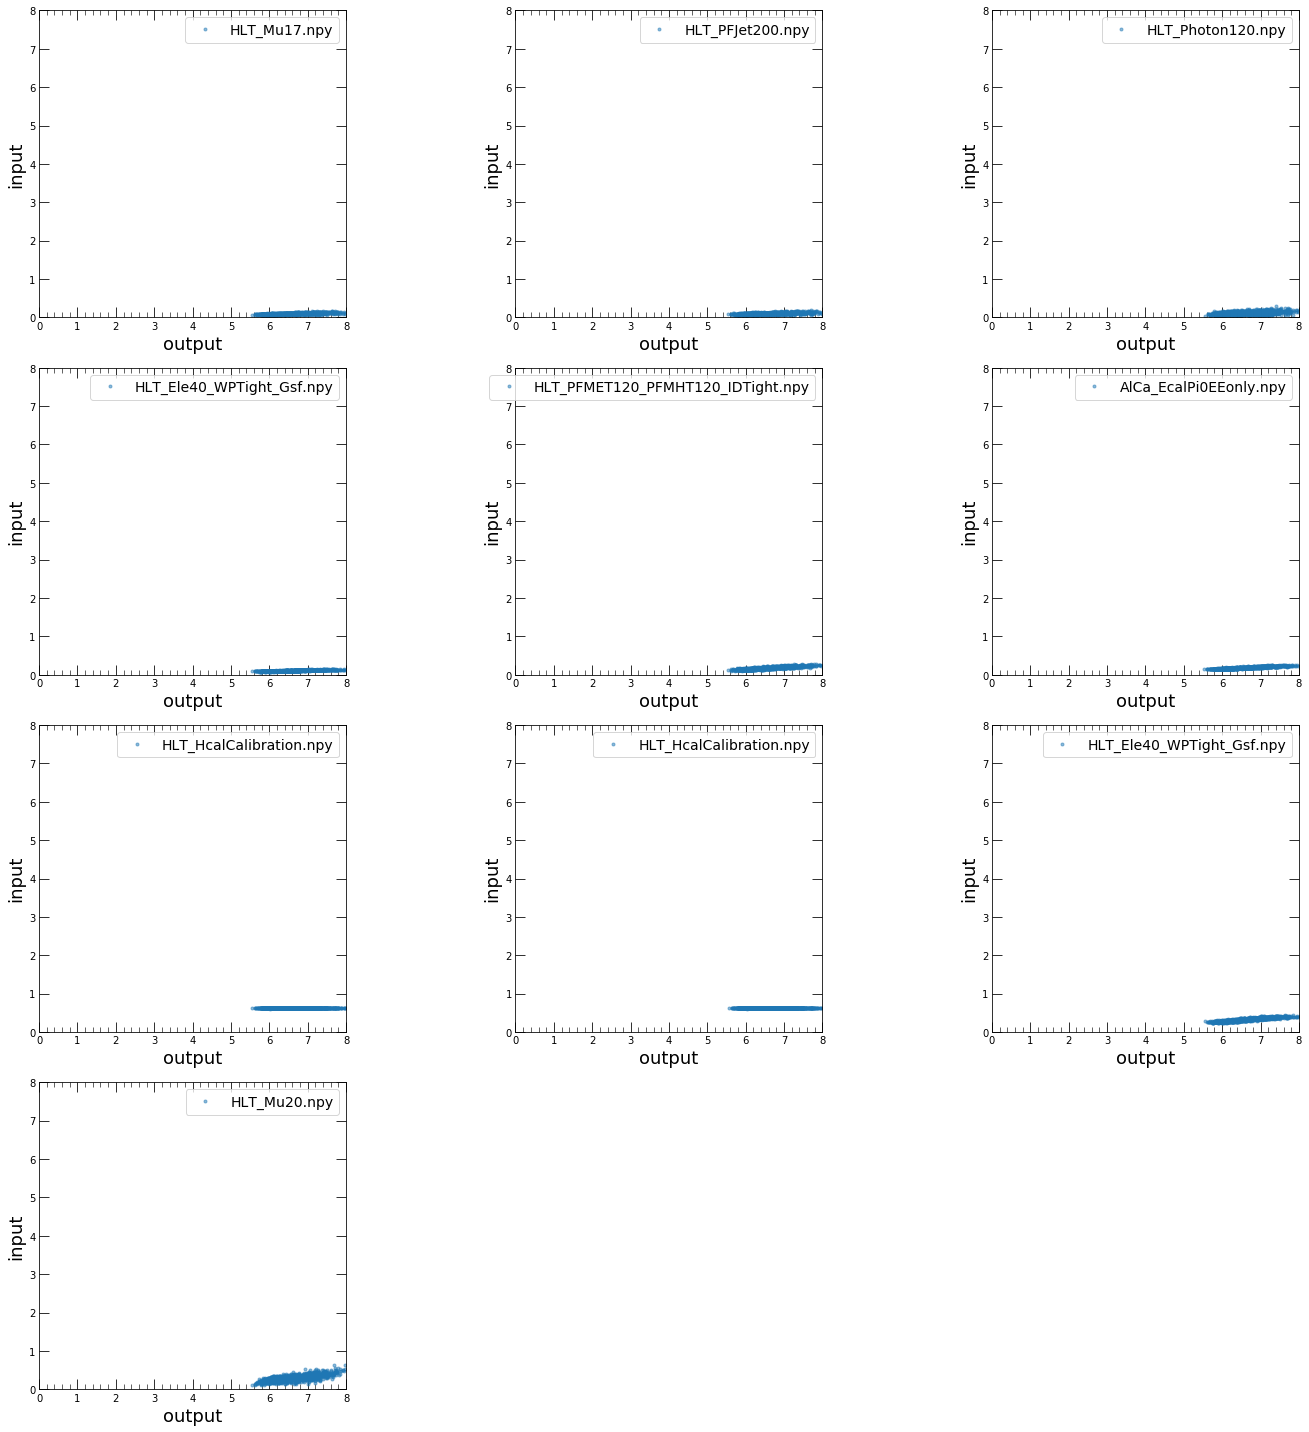

In [63]:
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.plot(outp_all_bad[i],inp_all_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,8)
    plt.ylim(0,8)
    plt.legend()    
plt.tight_layout()
plt.show()

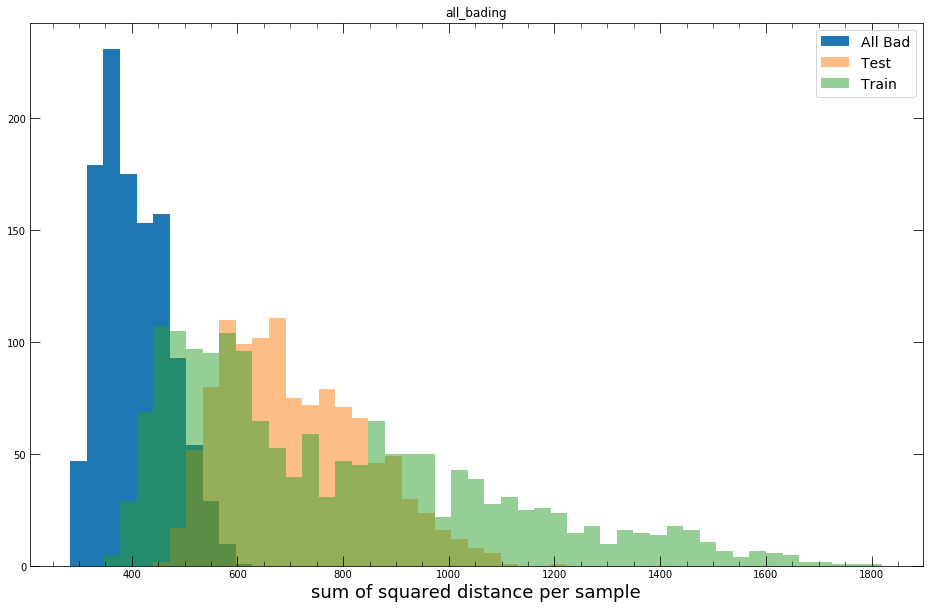

In [35]:
error_all_bad = []
for r in range(len(reconstructed_all_bad)):
    temp = 0
    for s in range(len(reconstructed_all_bad[r])):
        temp+=(reconstructed_all_bad[r][s]-all_bad[r][s])**2
    error_all_bad.append(temp)

plt.figure()
bins = np.linspace(min(min(error_test),min(error_train),min(error_all_bad)),max(max(error_test),max(error_train),max(error_all_bad)),50)
plt.hist(error_all_bad,bins=bins,label="All Bad")
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.legend()
plt.xlabel('sum of squared distance per sample')
plt.title('all_bading')
plt.show()

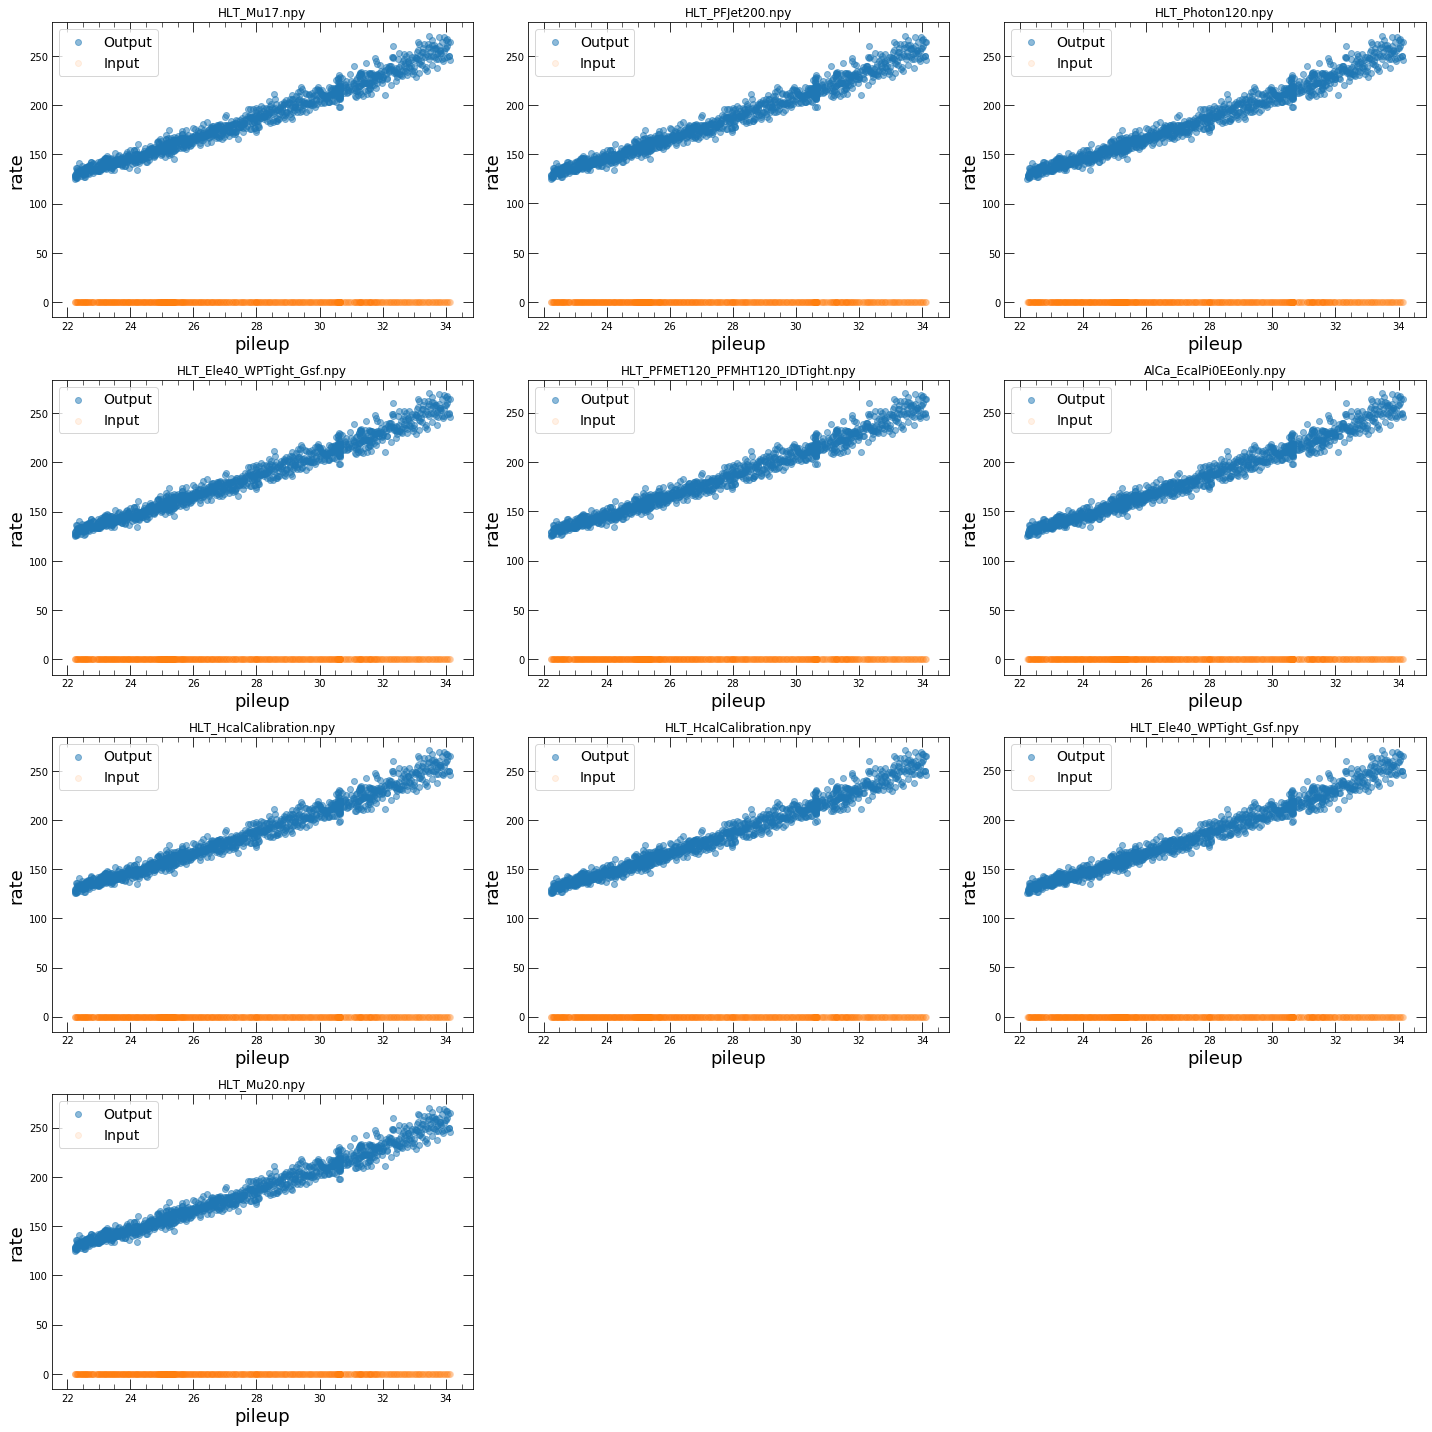

In [65]:
pileup_all_bad = data[str(runs[2])]['pileup'][0]

output_rates = []
input_rates = data[str(runs[2])]['rates']

for i in range(len(input_rates)):
    input_rates[i] = np.array(input_rates[i])/3

for r in range(num_rates):
    output_rates.append([])

for r in range(len(reconstructed_all_bad)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_all_bad[r][o]*pileup_all_bad[r])
    
plt.figure(figsize=fig_size)
              
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(pileup_all_bad,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_all_bad,input_rates[i],label='Input',alpha=.1)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Real Bad Data

In [37]:
with open(bad_data_file, 'rb') as handle:
    baddata = pickle.load(handle)

realbad2_runs = [301480]
x_bad2 = np.array(baddata[str(realbad2_runs[0])]['samples'])

real_bad = {}
real_bad.update({'301480' : {}})

In [38]:
realbad2_new = []
lumi_realbad2 = []
pileup = []
pile = baddata[str(realbad2_runs[0])]['pileup'][0]
lumirealbad2 = baddata[str(realbad2_runs[0])]['lumiid']

for l in range(len(x_bad2)):
    if not 0 in x_bad2[l]:
        realbad2_new.append(x_bad2[l])
        lumi_realbad2.append(lumirealbad2[l])
        pileup.append(pile[l])
            
lumirealbad2 = []
for n in lumi_realbad2:
    if n not in lumirealbad2:
        lumirealbad2.append(n)
    
                
reconstructed_realbad2 = model.predict(np.array(realbad2_new))

error_realbad2 = abs(realbad2_new-reconstructed_realbad2)/realbad2_new

real_bad["301480"].update({"input" : realbad2_new})
real_bad["301480"].update({"output" : reconstructed_realbad2})

In [39]:
error_reformat_realbad2 = []
inp_realbad2 = []
outp_realbad2 = []
for i in range(num_rates):
    error_reformat_realbad2.append([])
    inp_realbad2.append([])
    outp_realbad2.append([])

for i in range(len(error_realbad2)):
    for j in range(num_rates):
        error_reformat_realbad2[j].append(error_realbad2[i][j])
        outp_realbad2[j].append(reconstructed_realbad2[i][j])
        inp_realbad2[j].append(realbad2_new[i][j])

real_bad["301480"].update({"relative error" : error_reformat_realbad2})

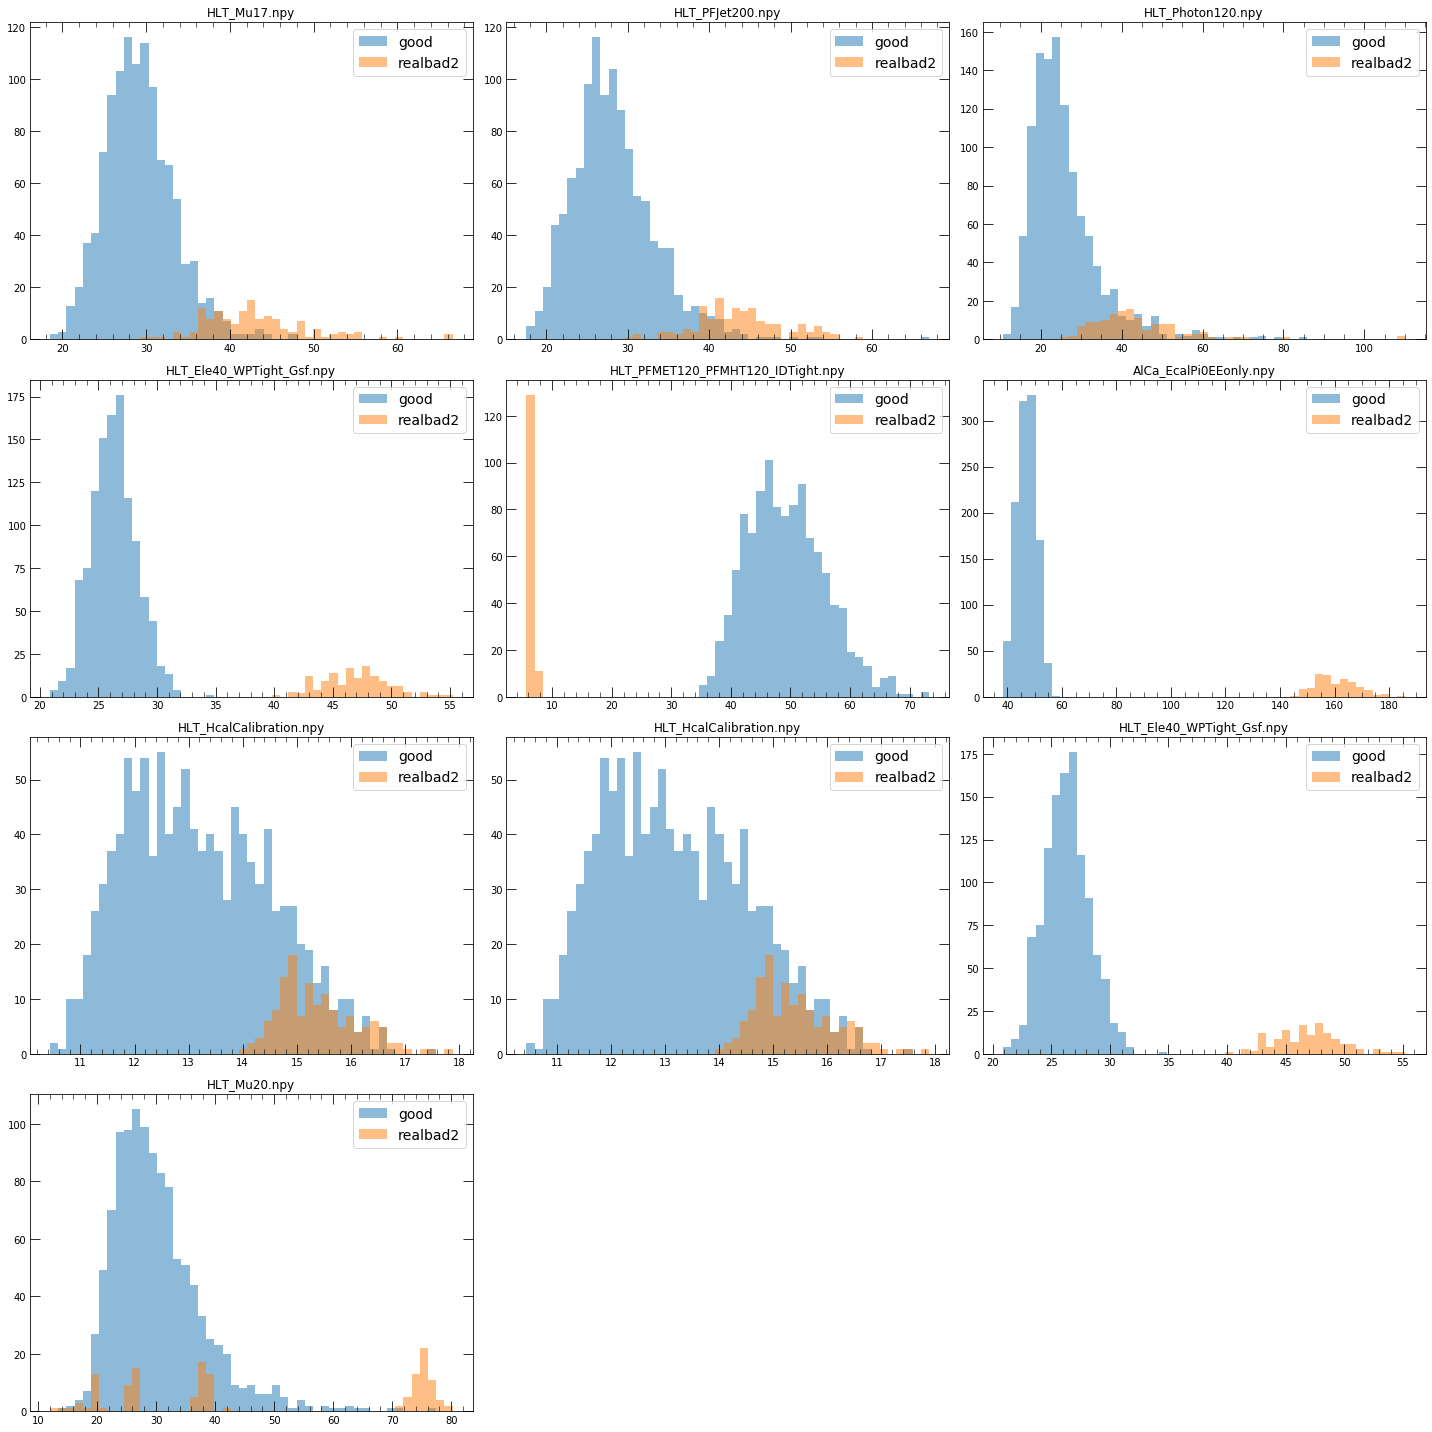

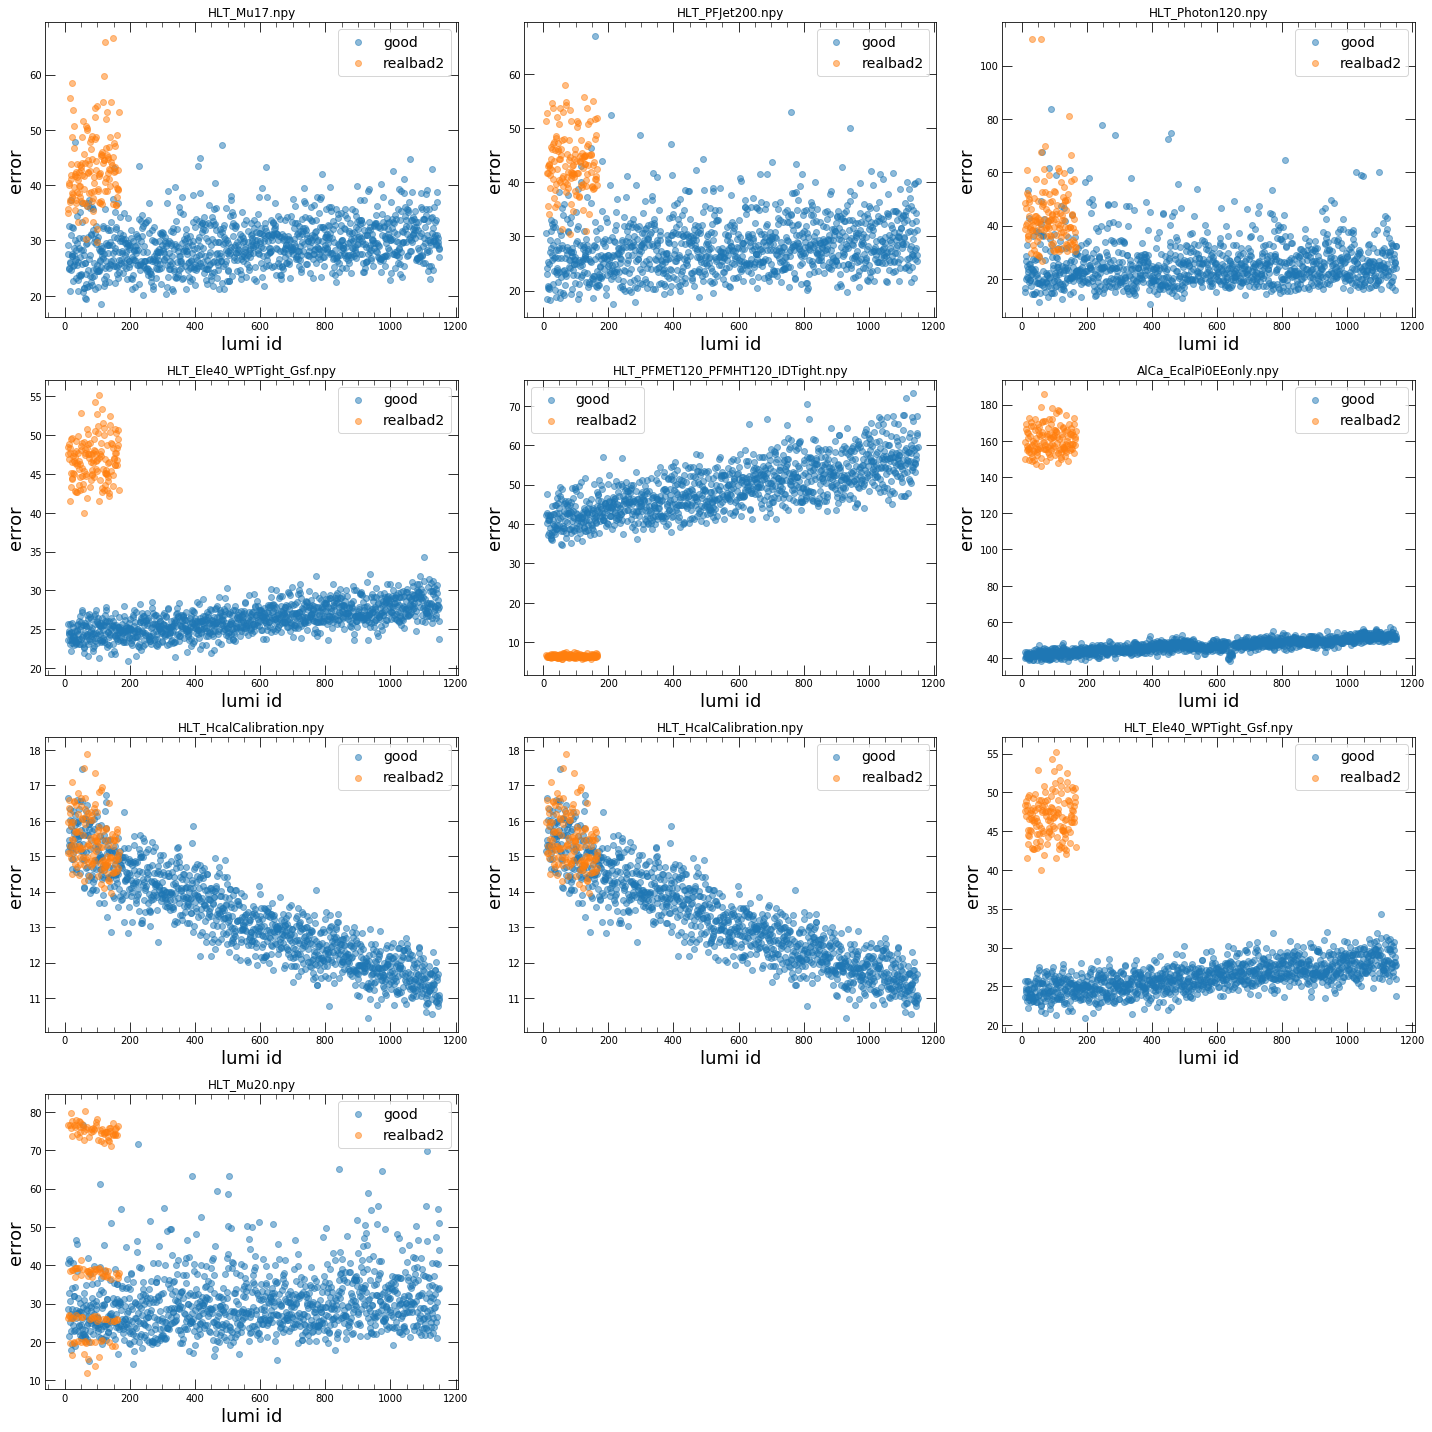

In [40]:
plt.figure(figsize=fig_size)
for i in range(len(error_reformat_realbad2)):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_realbad2[i])),max(max(error_test_reformat[i]),max(error_reformat_realbad2[i])),50)
    plt.hist(error_test_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_realbad2[i],bins=bins,label='realbad2',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumirealbad2,error_reformat_realbad2[i],label='realbad2',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

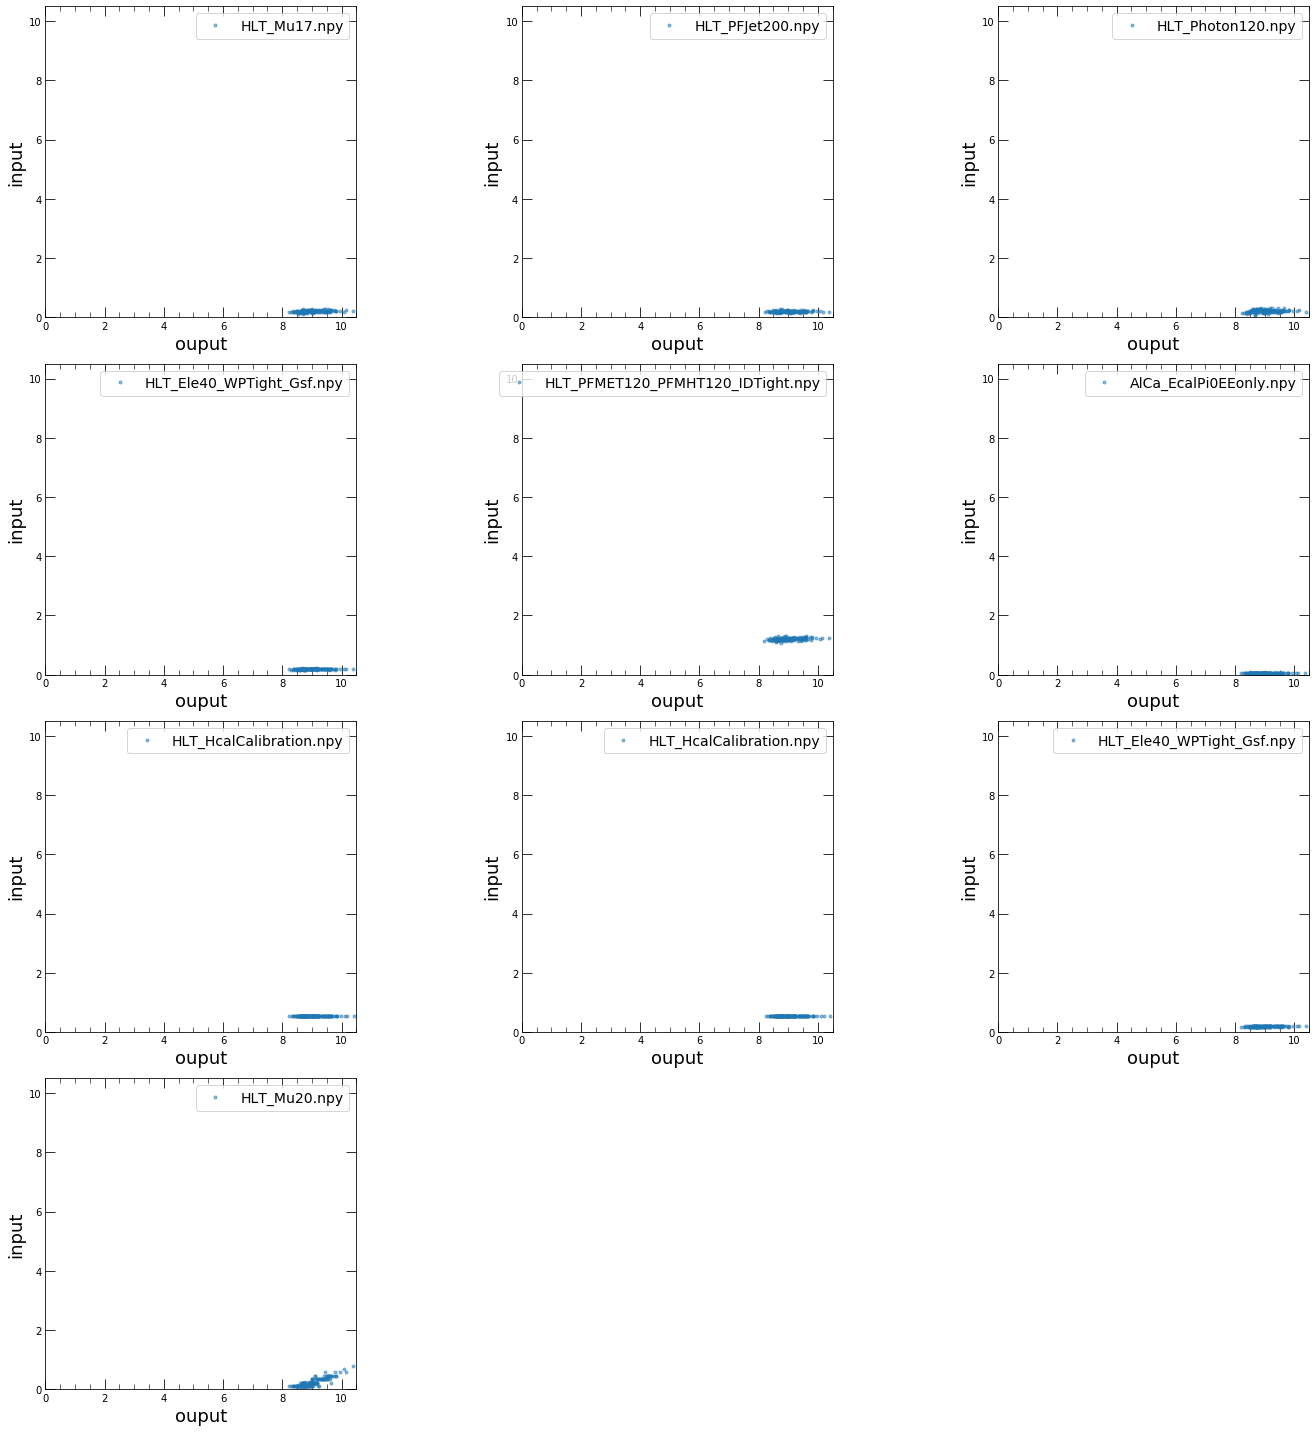

In [66]:
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.plot(outp_realbad2[i],inp_realbad2[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,10.5)
    plt.ylim(0,10.5)
    plt.legend()    
plt.tight_layout()
plt.show()

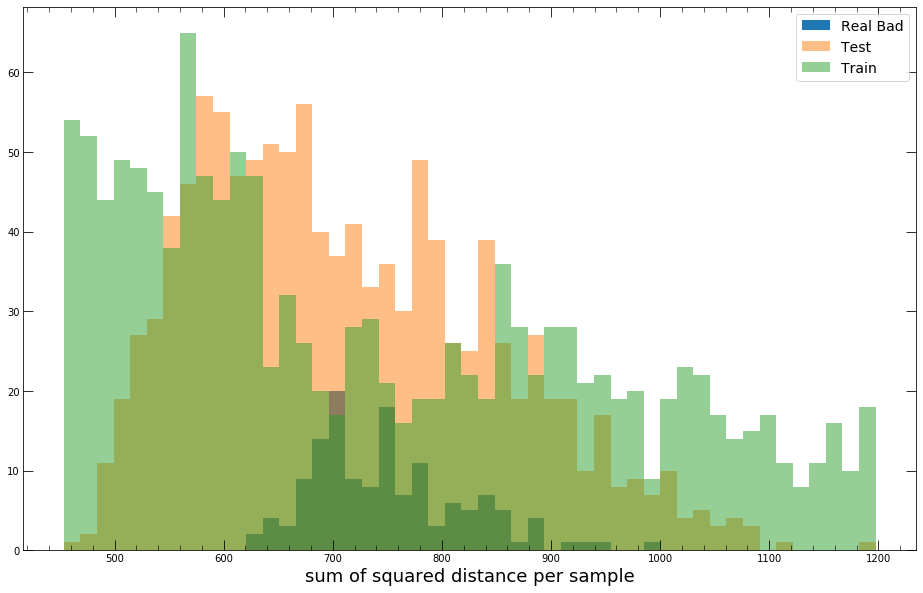

In [67]:
error_realbad2 = []
for r in range(len(reconstructed_realbad2)):
    temp = 0
    for s in range(len(reconstructed_realbad2[r])):
        temp+=(reconstructed_realbad2[r][s]-realbad2_new[r][s])**2
    error_realbad2.append(temp)

real_bad["301480"].update({"squared difference" : error_realbad2})

plt.figure()
bins = np.linspace(min(min(error_test),min(error_realbad2)),max(max(error_test),max(error_realbad2)),50)
plt.hist(error_realbad2,bins=bins,label='Real Bad')
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.legend()
plt.xlabel('sum of squared distance per sample')
plt.show()

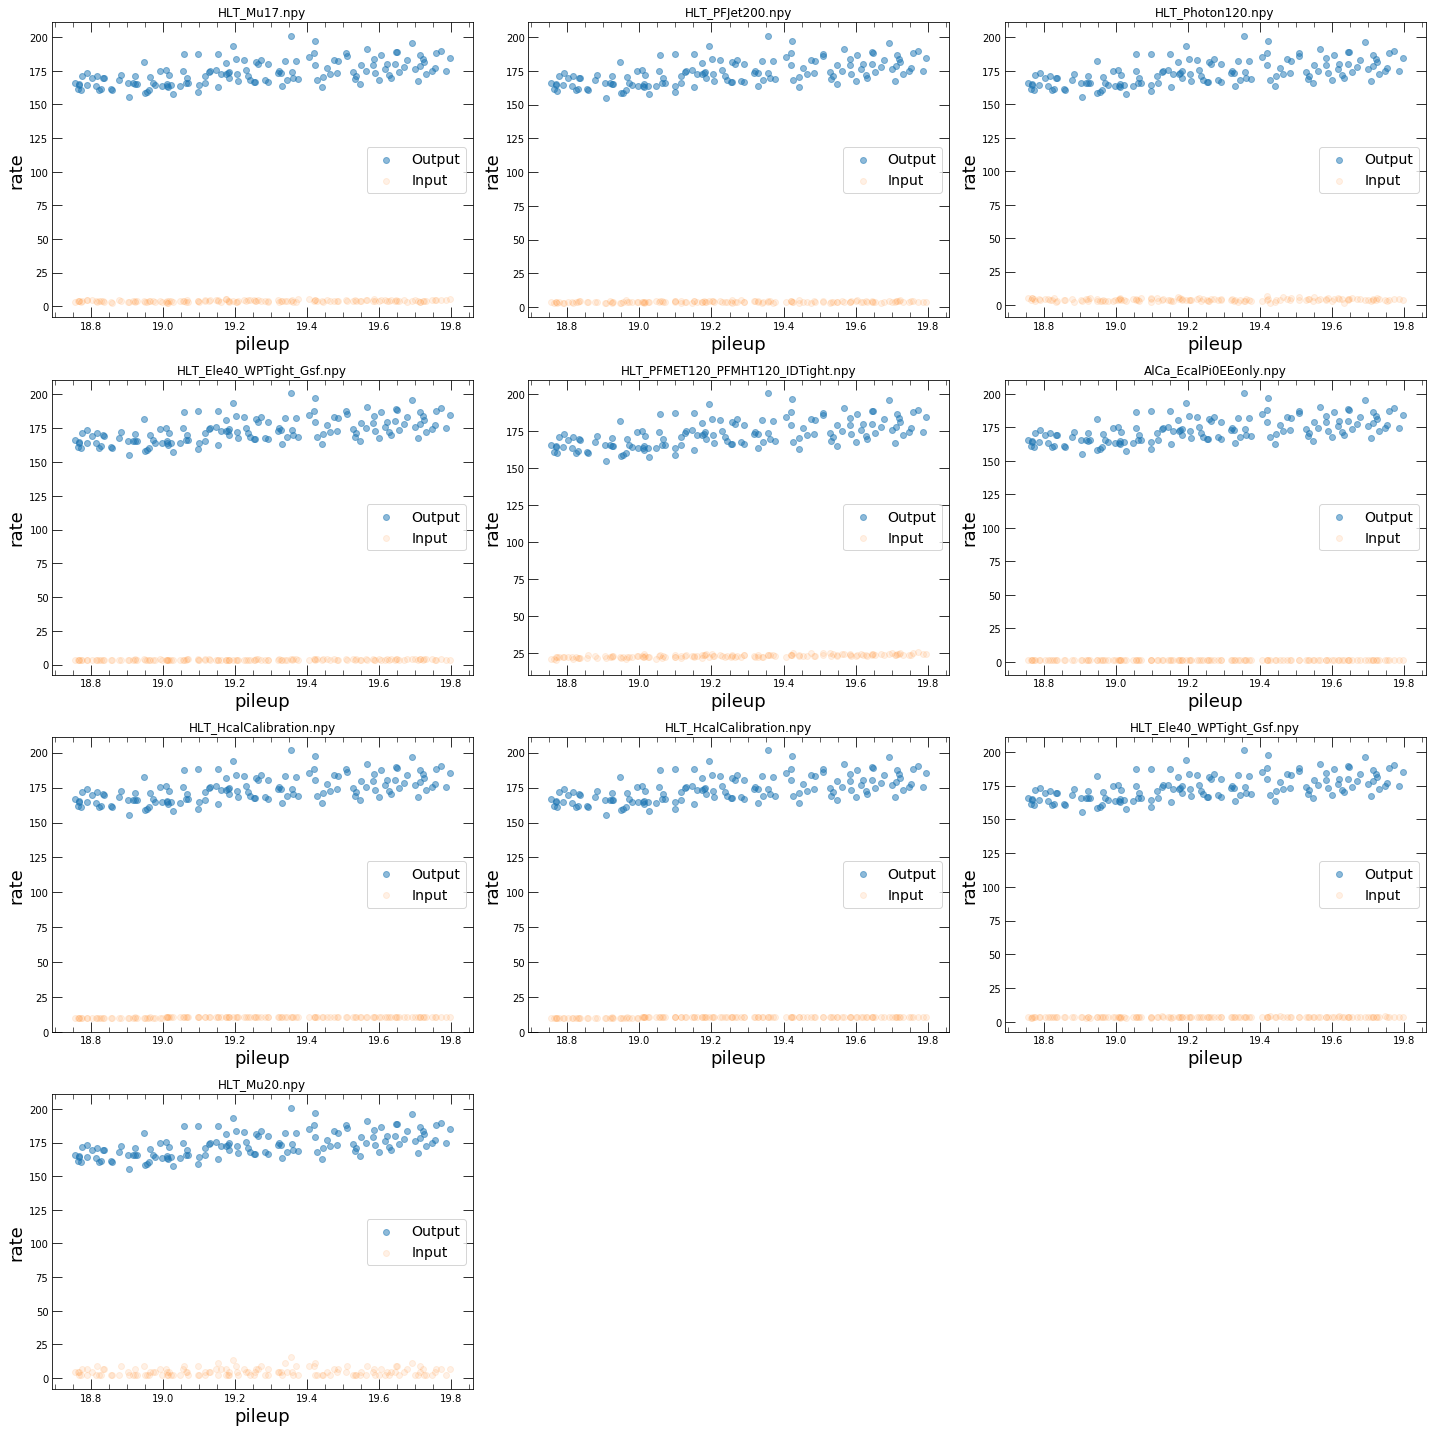

In [43]:
output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_realbad2)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_realbad2[r][o]*pileup[r])
        input_rates[o].append(realbad2_new[r][o]*pileup[r])
    
plt.figure(figsize=fig_size)
              
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(pileup,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup,input_rates[i],label='Input',alpha=.1)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Real Bad Data

In [44]:
realbad1_runs = [305588]
x_bad1 = np.array(baddata[str(realbad1_runs[0])]['samples'])

In [45]:
realbad1_new = []
lumi_realbad1 = []
pileup = []
pile = baddata[str(realbad1_runs[0])]['pileup'][0]
lumirealbad1 = baddata[str(realbad1_runs[0])]['lumiid']

for l in range(len(x_bad1)):
    if not 0 in x_bad1[l]:
        realbad1_new.append(x_bad1[l])
        lumi_realbad1.append(lumirealbad1[l])
        pileup.append(pile[l])
            
lumirealbad1 = []
for n in lumi_realbad1:
    if n not in lumirealbad1:
        lumirealbad1.append(n)
    
                
reconstructed_realbad1 = model.predict(np.array(realbad1_new))

error_realbad1 = abs(realbad1_new-reconstructed_realbad1)/realbad1_new

In [46]:
error_reformat_realbad1 = []
inp_realbad1 = []
outp_realbad1 = []
for i in range(num_rates):
    error_reformat_realbad1.append([])
    inp_realbad1.append([])
    outp_realbad1.append([])

for i in range(len(error_realbad1)):
    for j in range(num_rates):
        error_reformat_realbad1[j].append(error_realbad1[i][j])
        outp_realbad1[j].append(reconstructed_realbad1[i][j])
        inp_realbad1[j].append(realbad1_new[i][j])

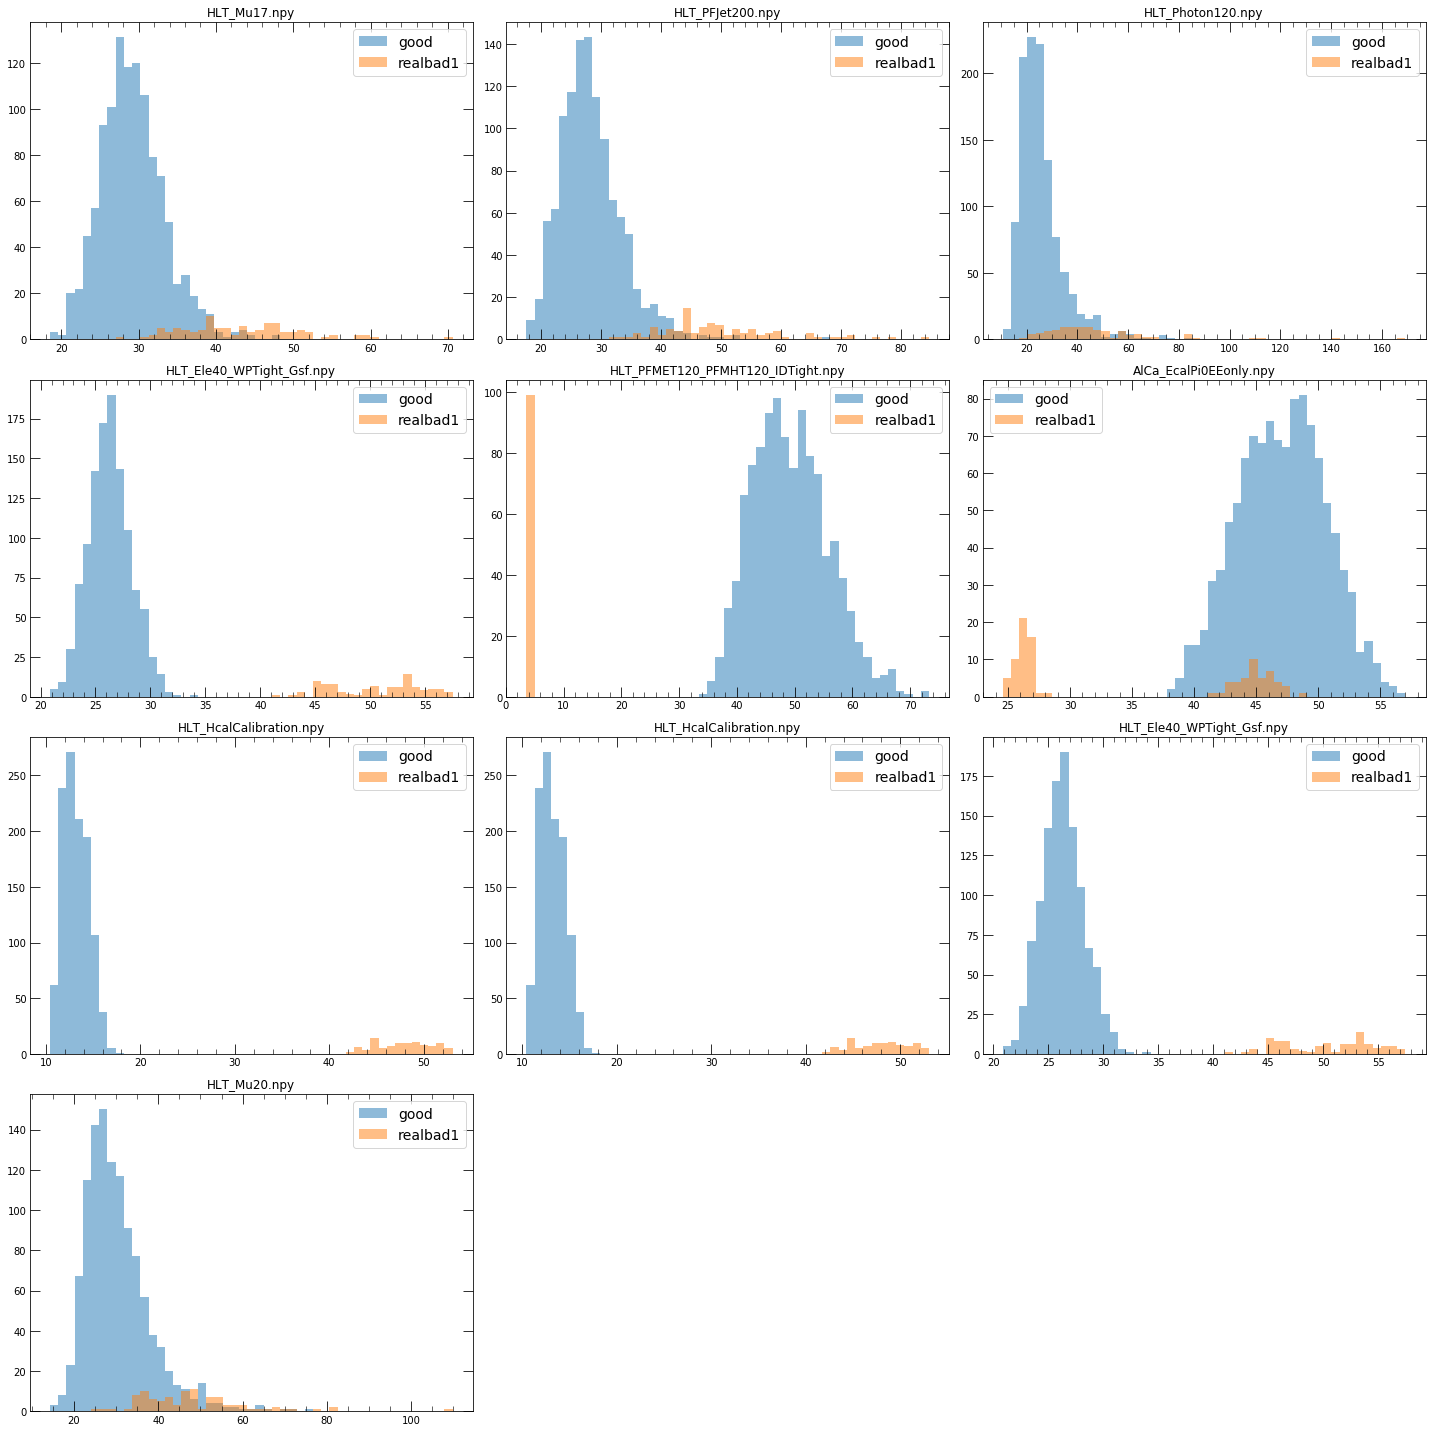

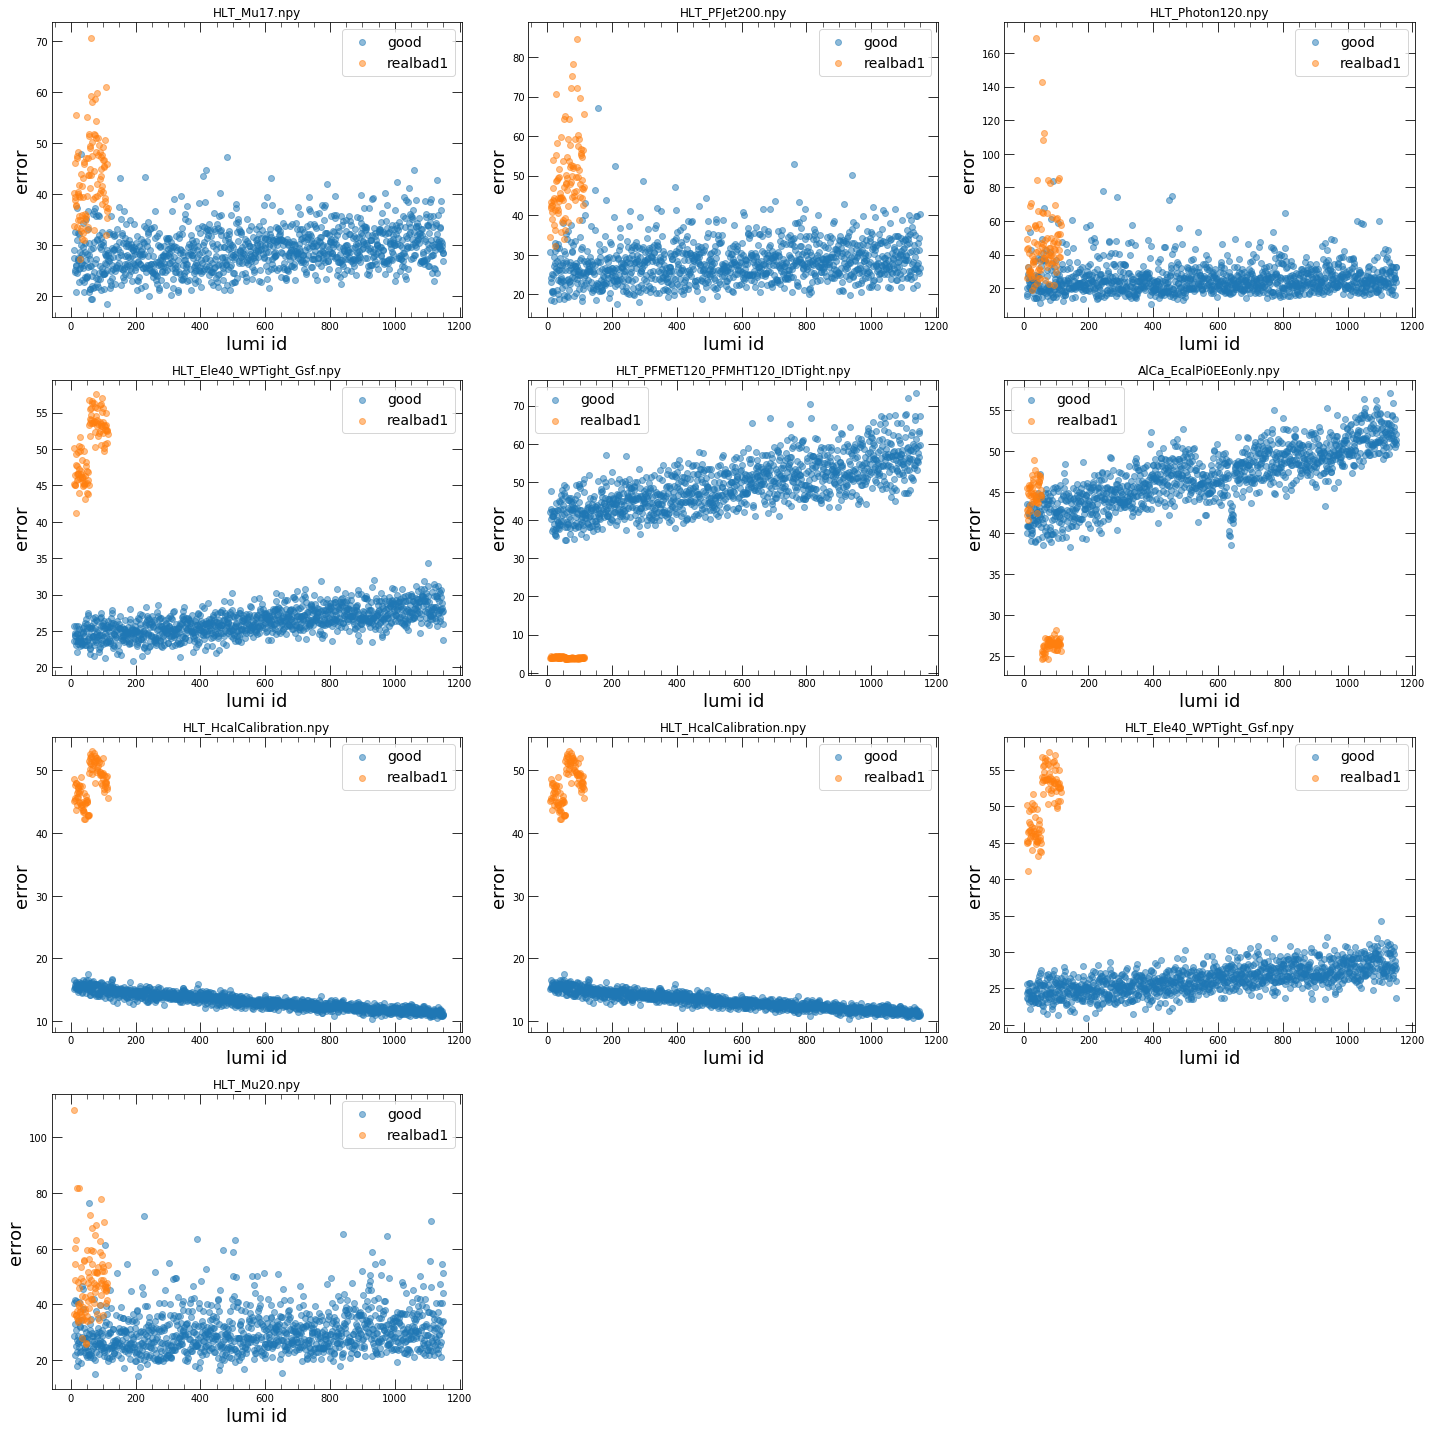

In [47]:
bins  = 'auto'
plt.figure(figsize=fig_size)
for i in range(len(error_reformat_realbad1)):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_realbad1[i])),max(max(error_test_reformat[i]),max(error_reformat_realbad1[i])),50)
    plt.hist(error_test_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_realbad1[i],bins=bins,label='realbad1',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumirealbad1,error_reformat_realbad1[i],label='realbad1',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

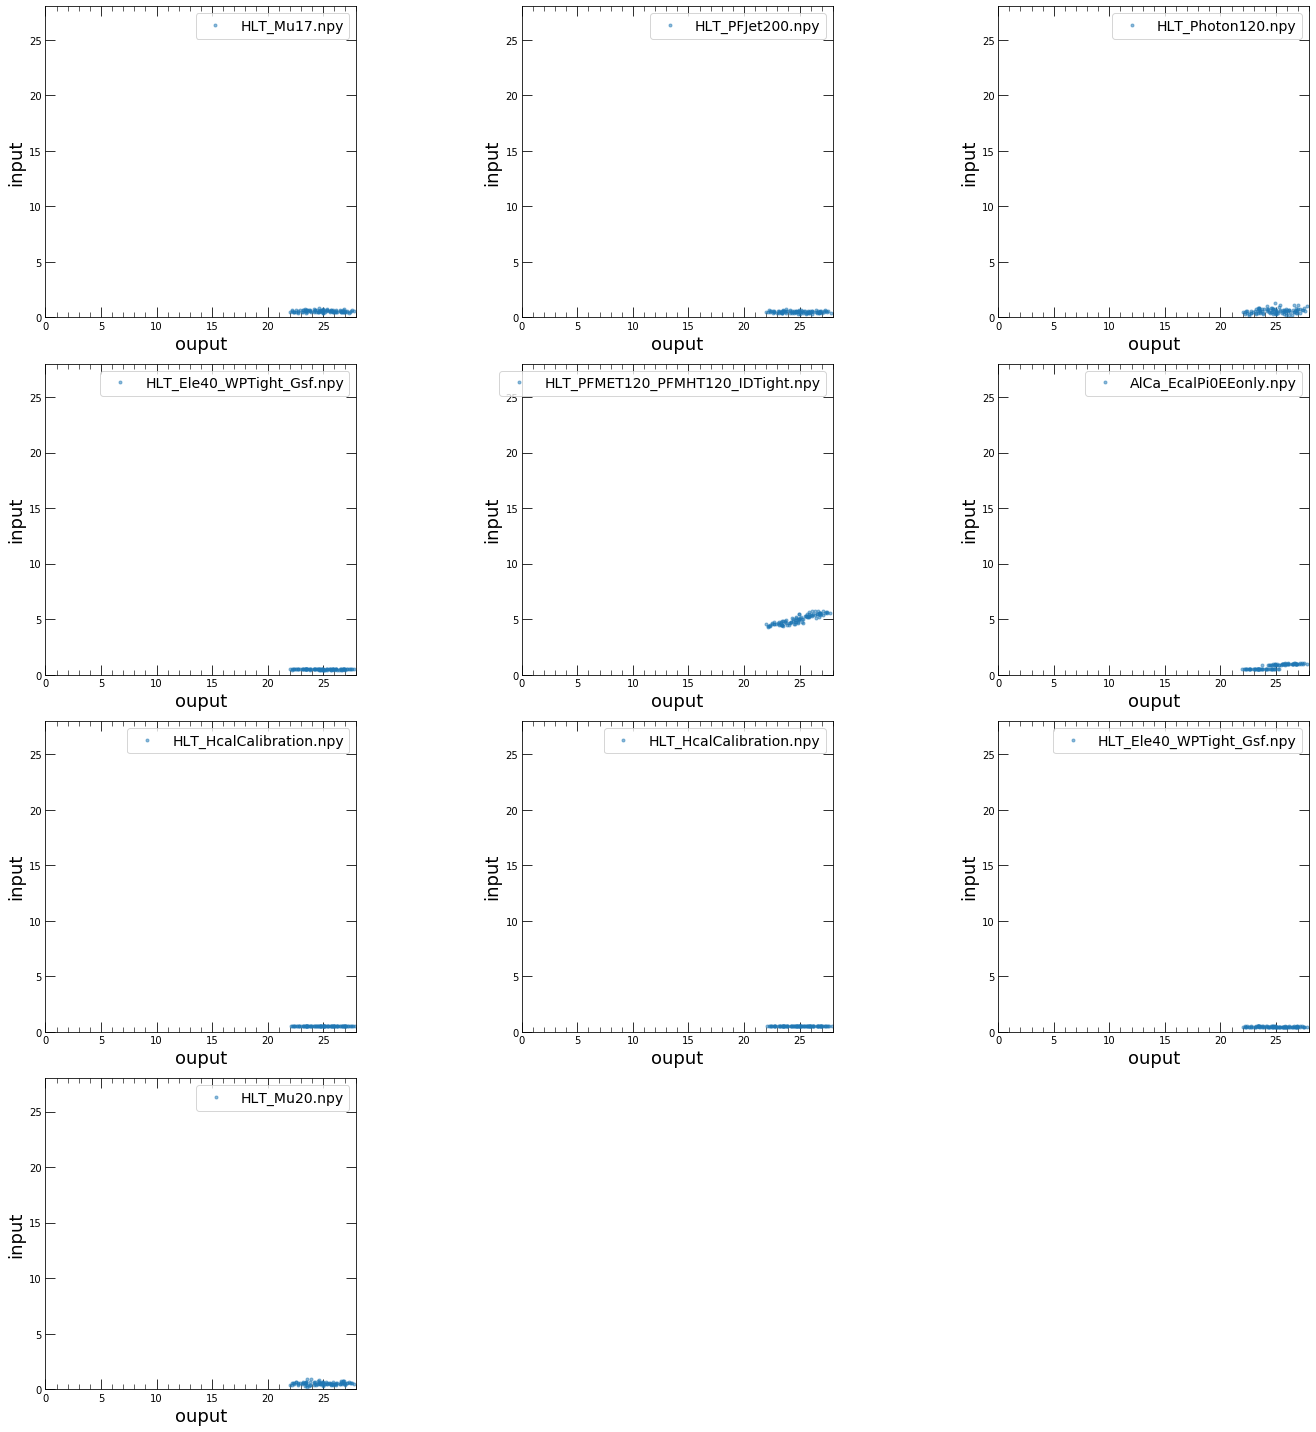

In [68]:
plt.figure(figsize=fig_size)
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.plot(outp_realbad1[i],inp_realbad1[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,28)
    plt.ylim(0,28)
    plt.legend()    
plt.tight_layout()
plt.show()

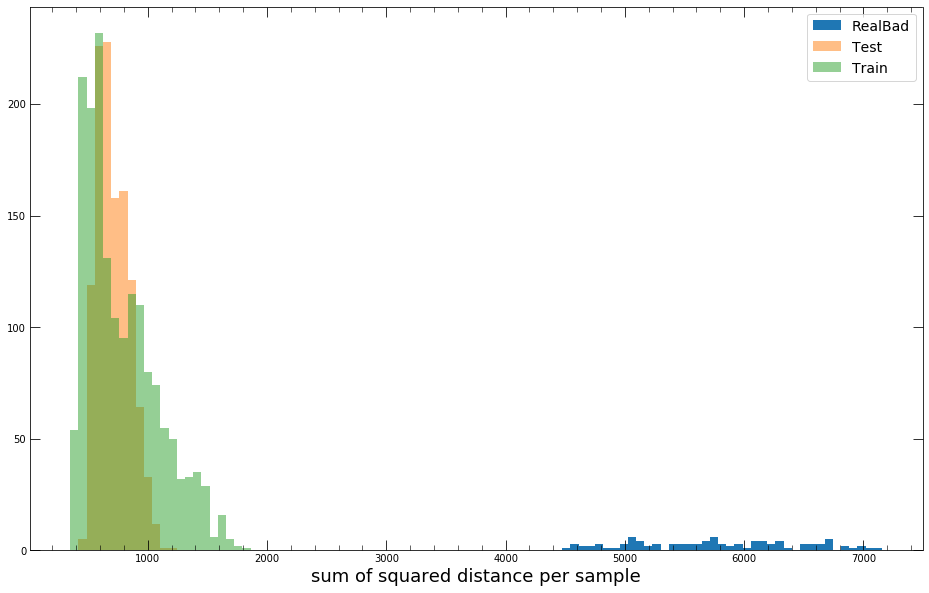

In [49]:
error_realbad1 = []
for r in range(len(reconstructed_realbad1)):
    temp = 0
    for s in range(len(reconstructed_realbad1[r])):
        temp+=(reconstructed_realbad1[r][s]-realbad1_new[r][s])**2
    error_realbad1.append(temp)

plt.figure()
bins = np.linspace(min(min(error_realbad1),min(error_test),min(error_train)),max(max(error_realbad1),max(error_test),max(error_train)),100)
plt.hist(error_realbad1,bins=bins,label='RealBad')
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.xlabel('sum of squared distance per sample')
plt.legend()
plt.show()

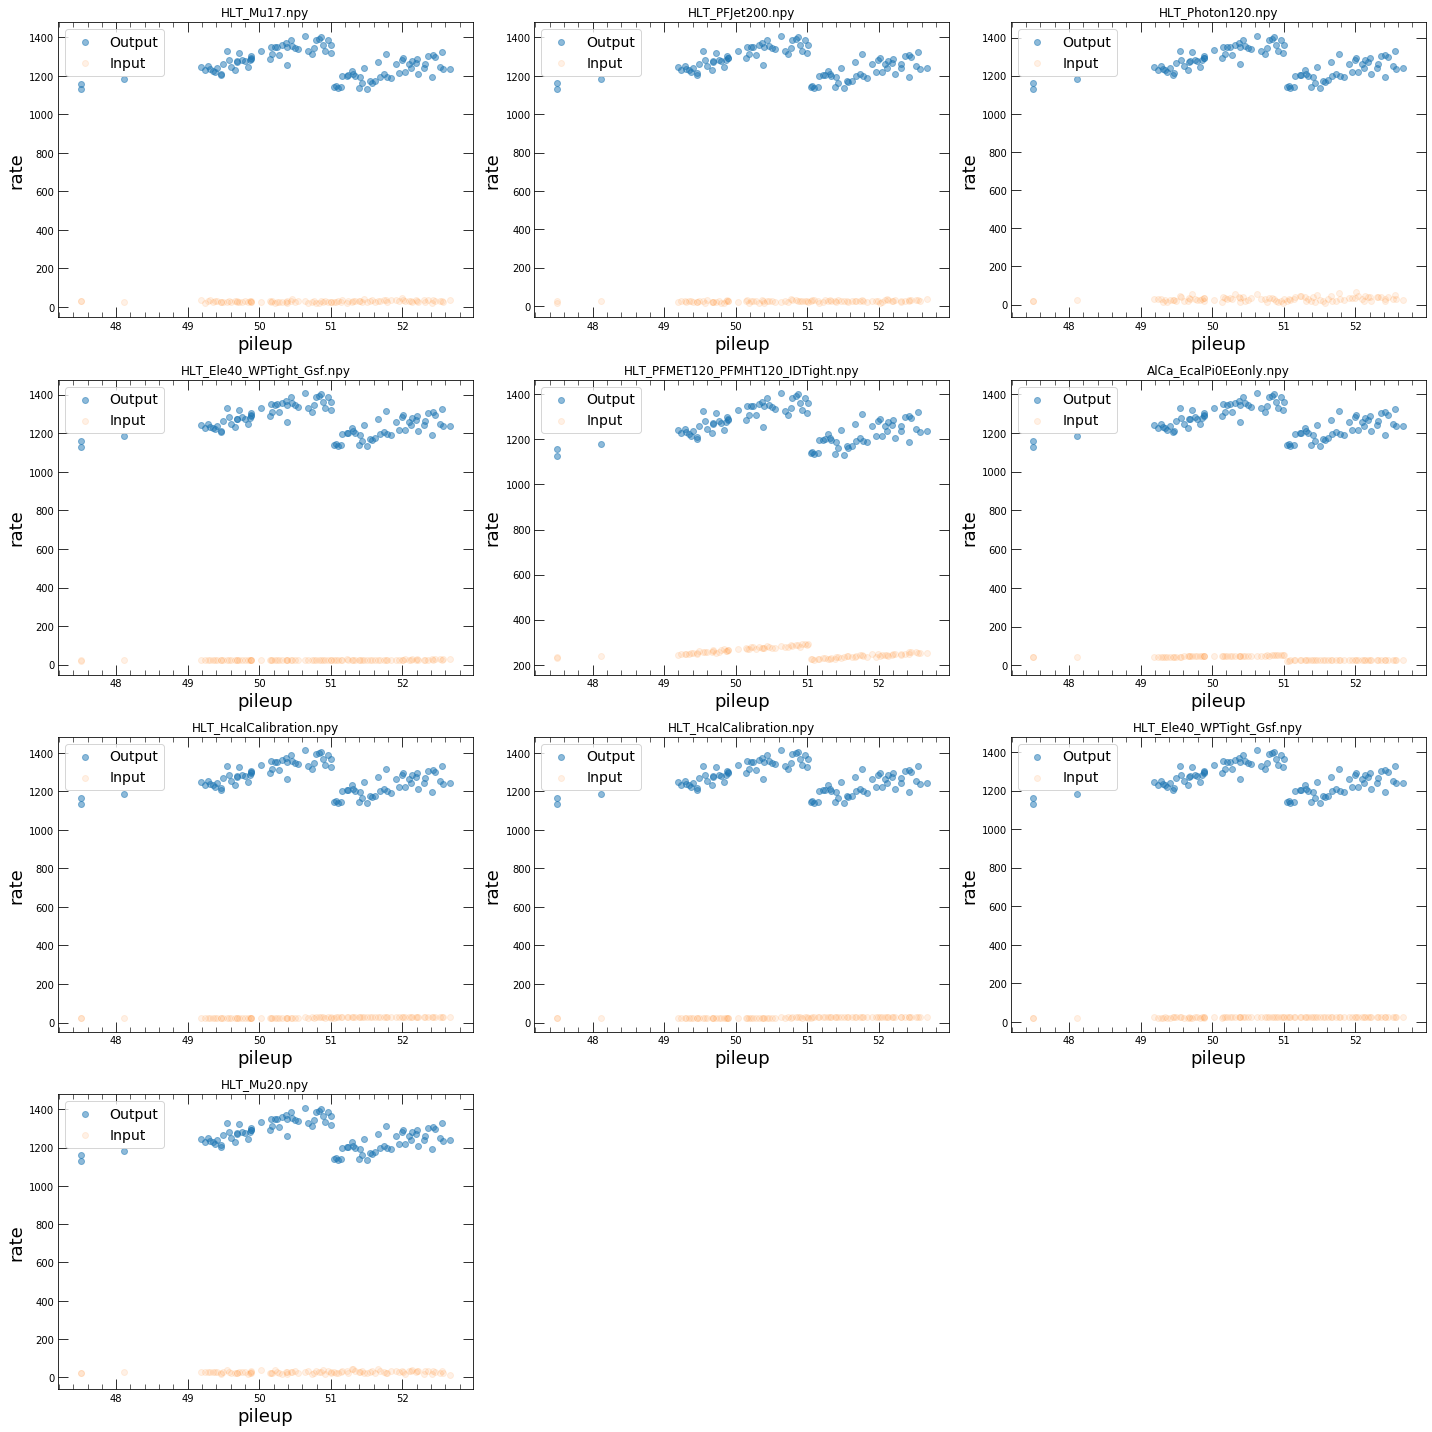

In [50]:
output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_realbad1)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_realbad1[r][o]*pileup[r])
        input_rates[o].append(realbad1_new[r][o]*pileup[r])
    
plt.figure(figsize=fig_size)
              
for i in range(num_rates):
    plt.subplot(subplot_size[0],subplot_size[1],i+1)
    plt.scatter(pileup,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup,input_rates[i],label='Input',alpha=.1)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

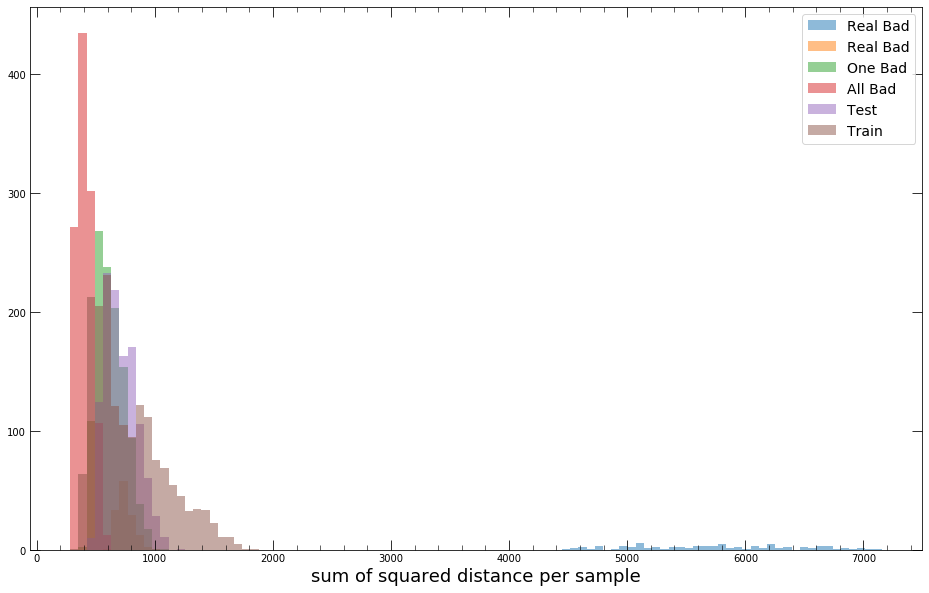

In [51]:
plt.figure()
bins = np.linspace(min(min(error_realbad1),min(error_test),min(error_train),min(error_realbad2),min(error_one_bad),min(error_all_bad)),max(max(error_realbad1),max(error_test),max(error_train),max(error_realbad2),max(error_one_bad),max(error_all_bad)),100)
plt.hist(error_realbad1,bins=bins,label='Real Bad',alpha=.5)
plt.hist(error_realbad2,bins=bins,label='Real Bad',alpha=.5)
plt.hist(error_one_bad,bins=bins,label='One Bad',alpha=.5)
plt.hist(error_all_bad,bins=bins,label='All Bad',alpha=.5)
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.xlabel('sum of squared distance per sample')
plt.legend()
#plt.ylim(0,100)
plt.show()